# Proximal Policy Optimization (PPO)

Proximal Policy Optimization (PPO) is a policy-gradient reinforcement learning algorithm that trains an *actor* (policy) and a *critic* (value function) together. It improves the policy using batches of collected trajectories while keeping updates “proximal” (not too large), which makes training more stable and sample-efficient than vanilla policy gradients.

Key ideas:
- **Actor–Critic**:  
  - Actor: outputs a probability distribution over actions.  
  - Critic: estimates the value function \(V(s)\) to reduce variance of gradient estimates.
- **Clipped objective**

  PPO uses a clipped surrogate objective to keep the new policy close to the old one:

  `L_clip(θ) = E_t[ min( r_t(θ) * A_t, clip(r_t(θ), 1 - ε, 1 + ε) * A_t ) ]`

  where

  `r_t(θ) = π_θ(a_t | s_t) / π_{θ_old}(a_t | s_t)`

  and `A_t` is the advantage estimate.

- **On-policy with mini-batches**:  
  Uses trajectories from the current policy, but performs multiple epochs of SGD on the same batch (with clipping to stay stable).
- **Generalized Advantage Estimation (GAE)**:  
  Often combined with PPO to compute smoother, lower-variance advantages from value predictions.

In practice, PPO is popular because it is relatively easy to implement, works well with neural networks, and tends to be robust across a variety of environments and hyperparameters.


Version log:
* 0.9 restart
    * using DQN lessons learned as template
* 0.10 fixed agent, oppo labels
* 0.11 horizontal, color swaps
* 0.12 learning not improved - dev paused or stopped
* 0.20 restarted with corrected  LA and ENV
* 0.30 restart redesign;
* 0.31 changed ENV weights
* 0.32 zero-sum approach
* 0.33 more center forced env

## Links, learning from
[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
[https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/](https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>


## Import dependecies and recheck installation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import pprint;
import pandas as pd
import os
from IPython.display import display, clear_output

import warnings

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090
cuda


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["PYTHONHASHSEED"] = str(SEED)

## Custom imports

In [3]:
from C4.connect4_env import Connect4Env
from C4.fast_connect4_lookahead import Connect4Lookahead
from PPO.ppo_training_phases_config import TRAINING_PHASES
from PPO.actor_critic import ActorCritic
from PPO.ppo_buffer import PPOBuffer, PPOHyperParams
from PPO.ppo_update import ppo_update, PPOUpdateCfg
from C4.connect4_board_display import Connect4_BoardDisplayer
from C4.plot_phase_summary import plot_phase_summary
from PPO.ppo_utilities import *
from PPO.ppo_live_plot import plot_live_training_ppo
from PPO.checkpoint import save_checkpoint, load_checkpoint
from DQN.dqn_utilities import *
from C4.connect4_board_display import display_final_boards_PPO
from PPO.ppo_opponent_sampler import OpponentSampler
from PPO.ppo_agent_eval import *
from PPO.ppo_loop_helpers import *
from C4.eval_oppo_dict import EVALUATION_OPPONENTS
from PPO.ppo_hall_of_fame import PPOHallOfFame
from PPO.LookaheadMentor import LookaheadMentor

Lookahead = Connect4Lookahead()

## Constants

In [4]:
plot_interval = 10 

In [5]:
LOG_DIR ="Logs/PPO/"
MODEL_DIR ="Models/PPO/"
PLOTS = "Plots/PPO/"
TEMP_DIR ="Models/PPO/TEMP/"           
reset_dir(TEMP_DIR)   

# Training phases

In [6]:
PHASES = PhaseTracker(TRAINING_PHASES)
L, lastPhase=display_phases_table(TRAINING_PHASES)
print(L, lastPhase)

phase,start_ep,end_ep,duration,length,lr,clip,entropy,epochs
L1_Spread,1,200,200,200,0.00012,0.2,0.005,4
L1_Force,201,500,300,500,0.00012,0.2,0.005,4


500 L1_Force


# Training session name - settings


In [7]:
SEED = True
SEED_EPOCHS = 16 #16
if not SEED: SEED_EPOCHS = 0
number_episodes = L # all
begin_start_time = time.time()
model_name = "RND_11"
run_name =  "Mentor"[:10]
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
tag = f"{run_name}-{lastPhase}-{model_name}-S-{SEED}-E-{SEED_EPOCHS}"
TRAINING_SESSION = f"PPQ-{number_episodes}-{tag} - at-{time_str}"
print("Start training session", TRAINING_SESSION)

Start training session PPQ-500-Mentor-L1_Force-RND_10-S-True-E-16 - at-2025-11-21 11-25-39


## Hall of Fame / policy ensemble

In [8]:
HOF_SPECS = {
    # name      # path (relative to notebook)
    "RDN_5":     "RND_5 PPO model.pt", 
    "RDN_6":     "RND_6 PPO model.pt", 
    "RDN_7":     "RND_7 PPO model.pt", 
    "RDN_8b":     "RND_8b PPO model.pt",
    "RDN_9":     "RND_9 PPO model.pt", 
    "RDN_10":     "RND_10 PPO model.pt",
    "RDN_11":     "RND_10 PPO model.pt",
}

hof = PPOHallOfFame(device=DEVICE)

HOF_METASCORES = {
    "RND_6": 0.667,
    "RND_7": 0.583,
    "RND_9": 0.583,
    "RND_5": 0.500,
    "RND_10": 0.500,
    "RND_8b": 0.417,
    "RND_11": 0.250,
}







for name, path in HOF_SPECS.items():
    hof.add_member(
        name=name,
        ckpt_path=path,
        metascore=HOF_METASCORES.get(name),
    )

print("HOF members:", hof.list_members())
POP_ENSEMBLE_NAMES = list(HOF_SPECS.keys())  # use all for now

pop_ensemble_policy = hof.build_ensemble(POP_ENSEMBLE_NAMES, use_metascore_weights=True)

for p in pop_ensemble_policy.parameters():
    p.requires_grad = False
pop_ensemble_policy.eval()
print(f"using {len(POP_ENSEMBLE_NAMES)} checkpoints in ensemble")

HOF members: ['RDN_5', 'RDN_6', 'RDN_7', 'RDN_8b', 'RDN_9', 'RDN_10']
using 6 checkpoints in ensemble


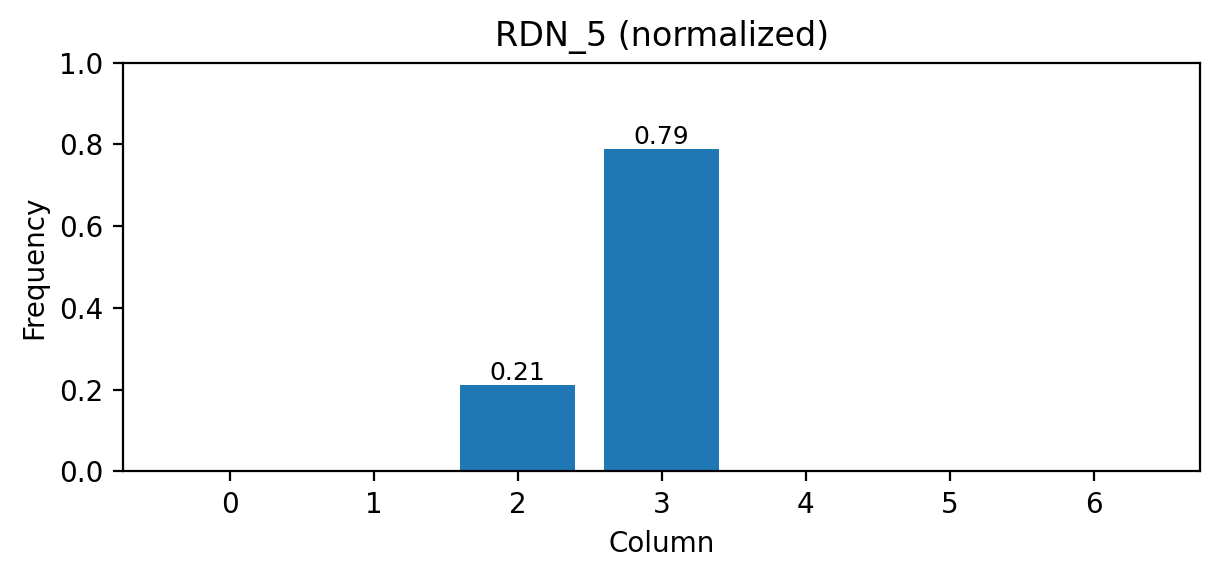

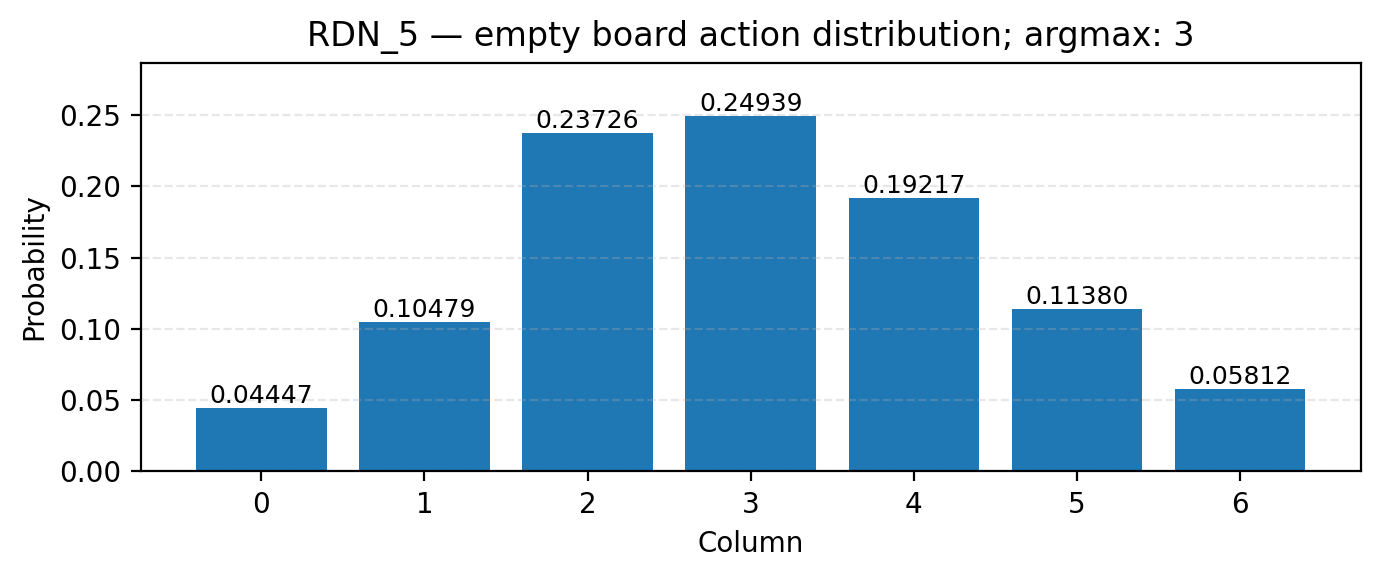

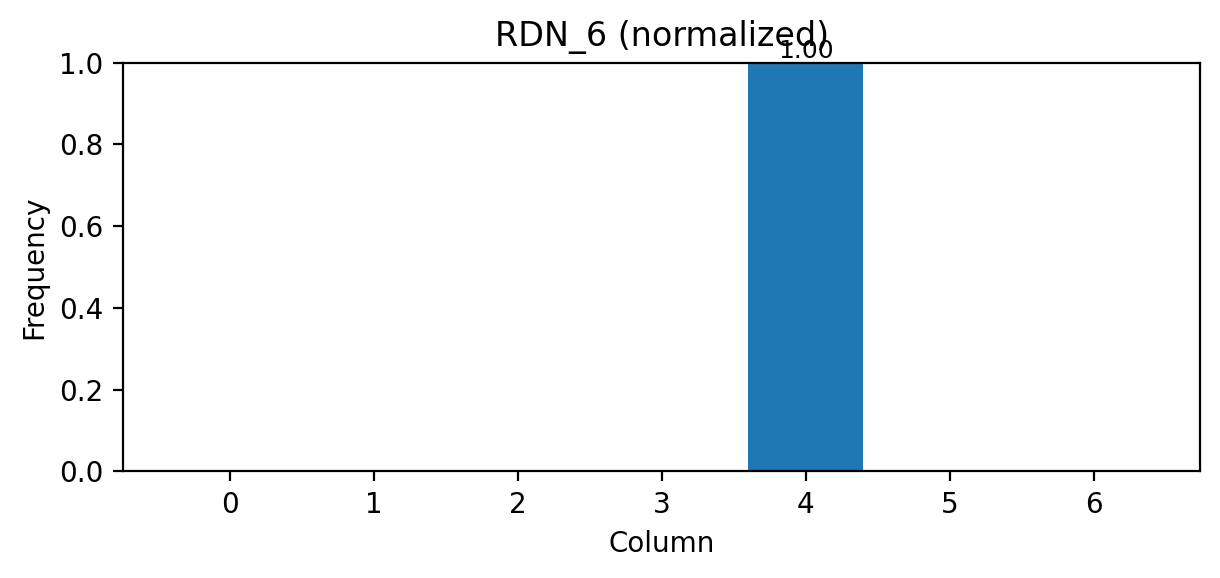

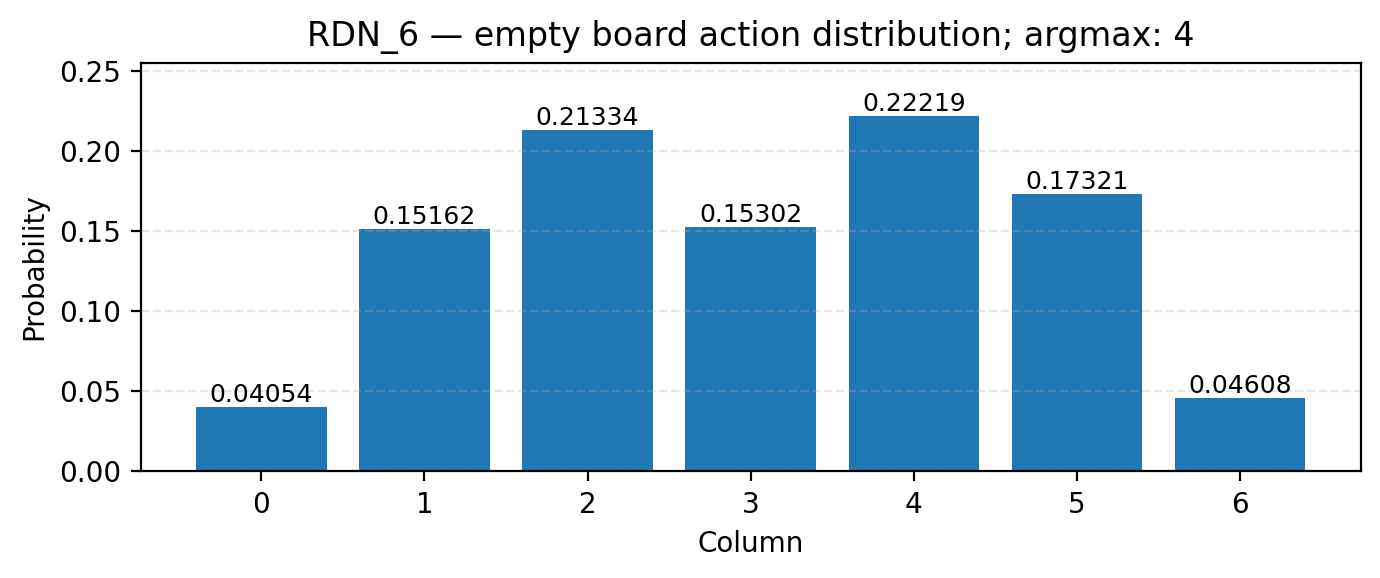

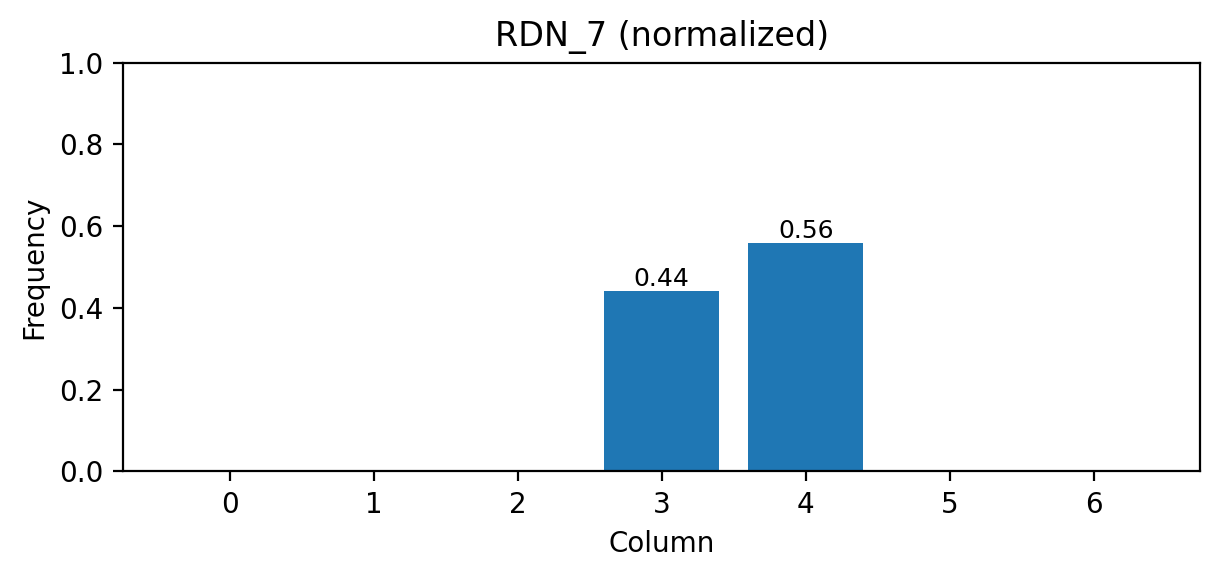

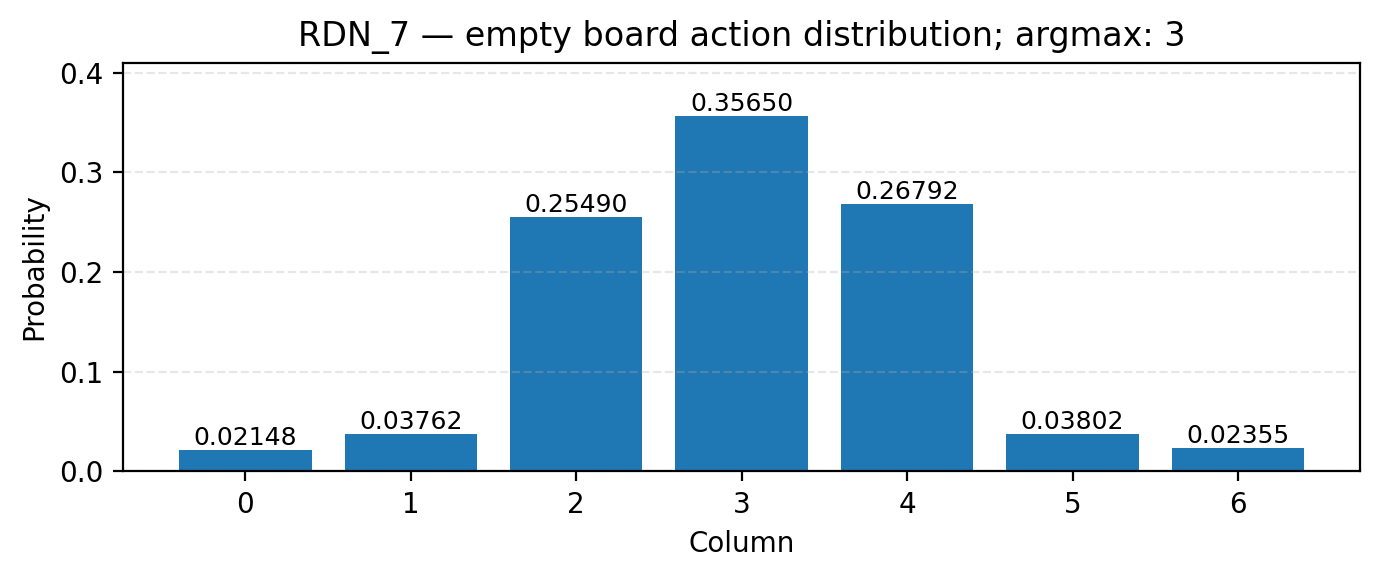

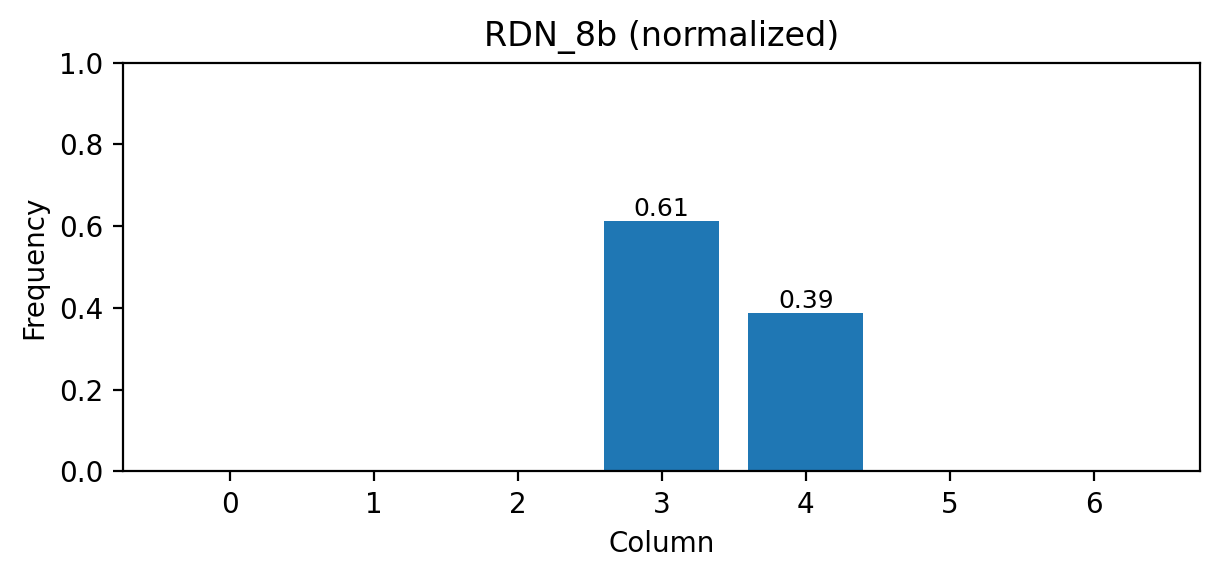

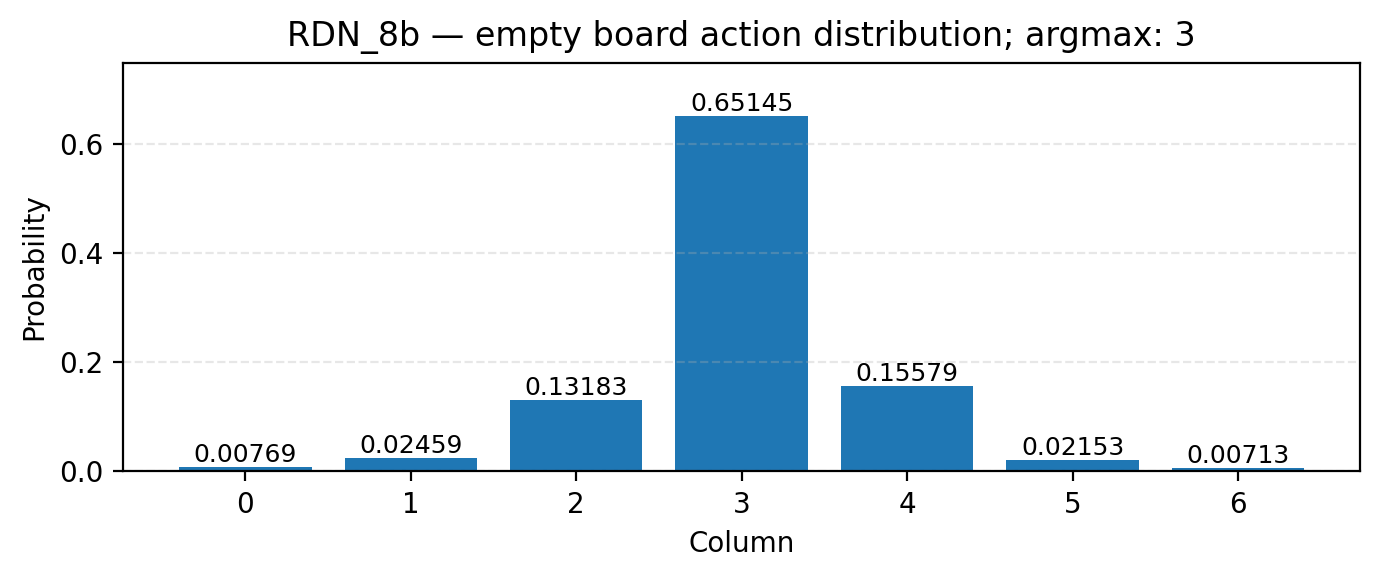

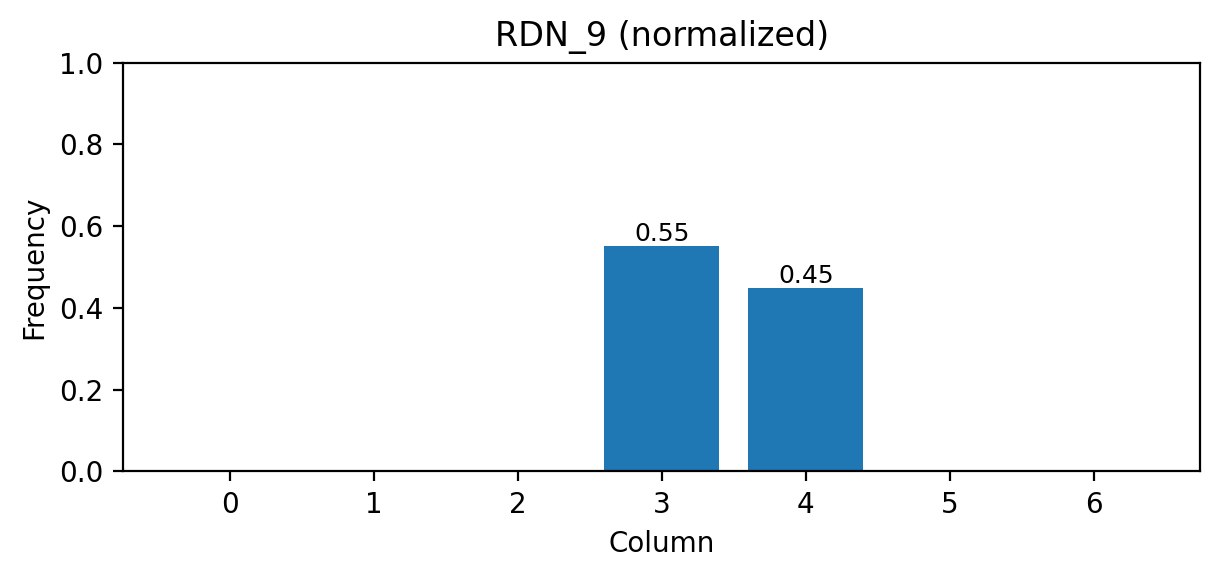

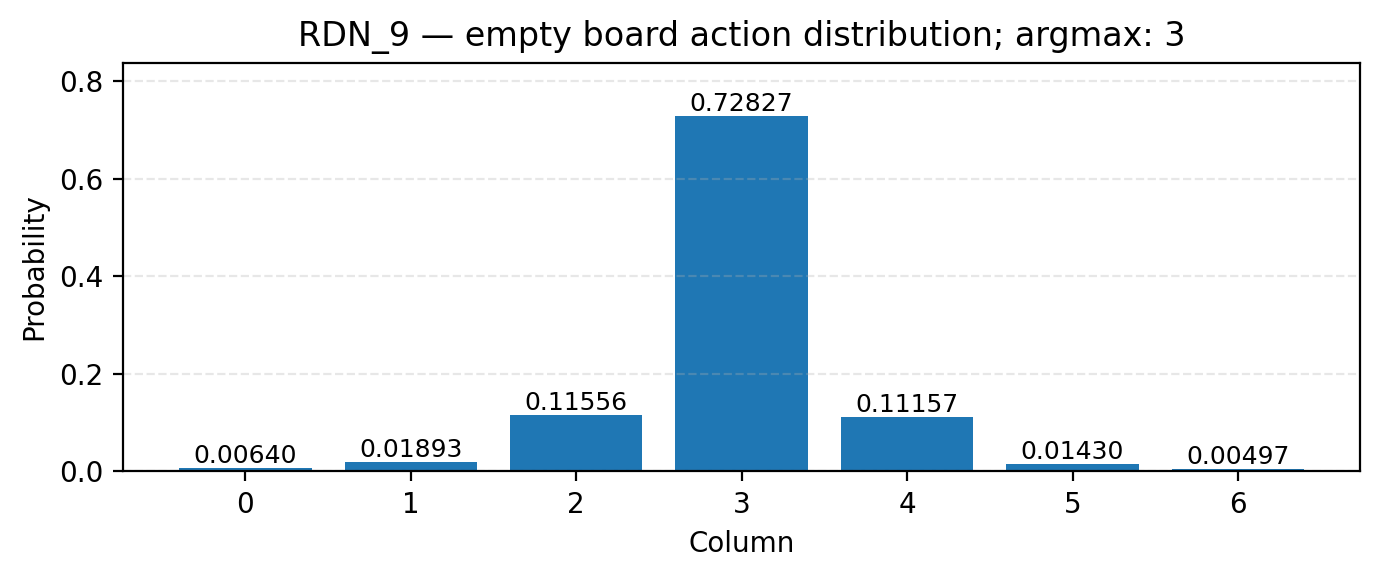

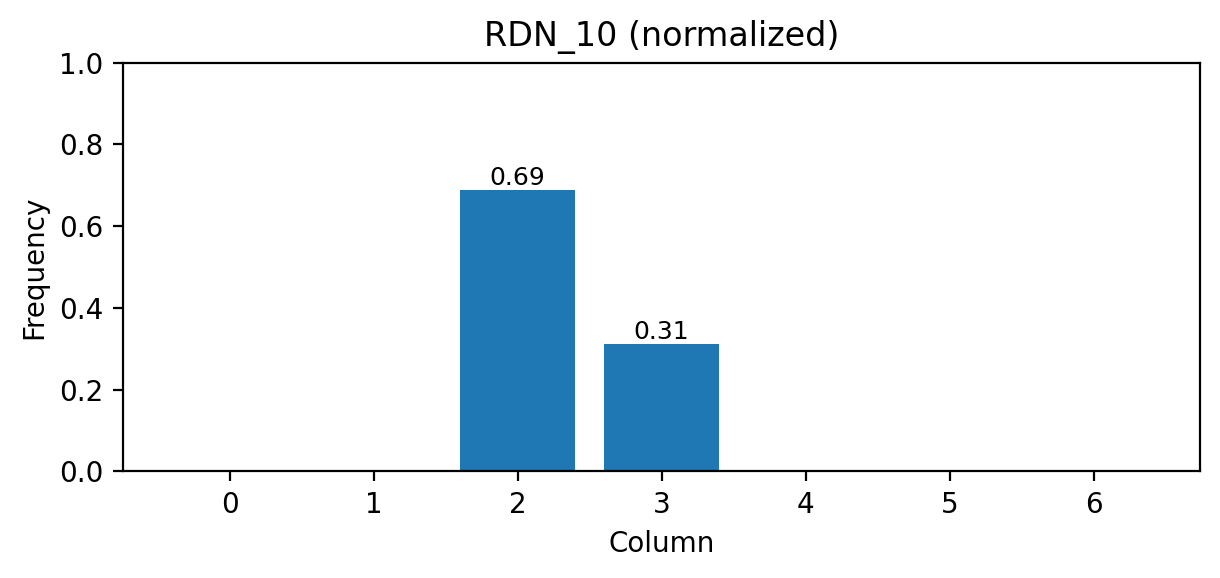

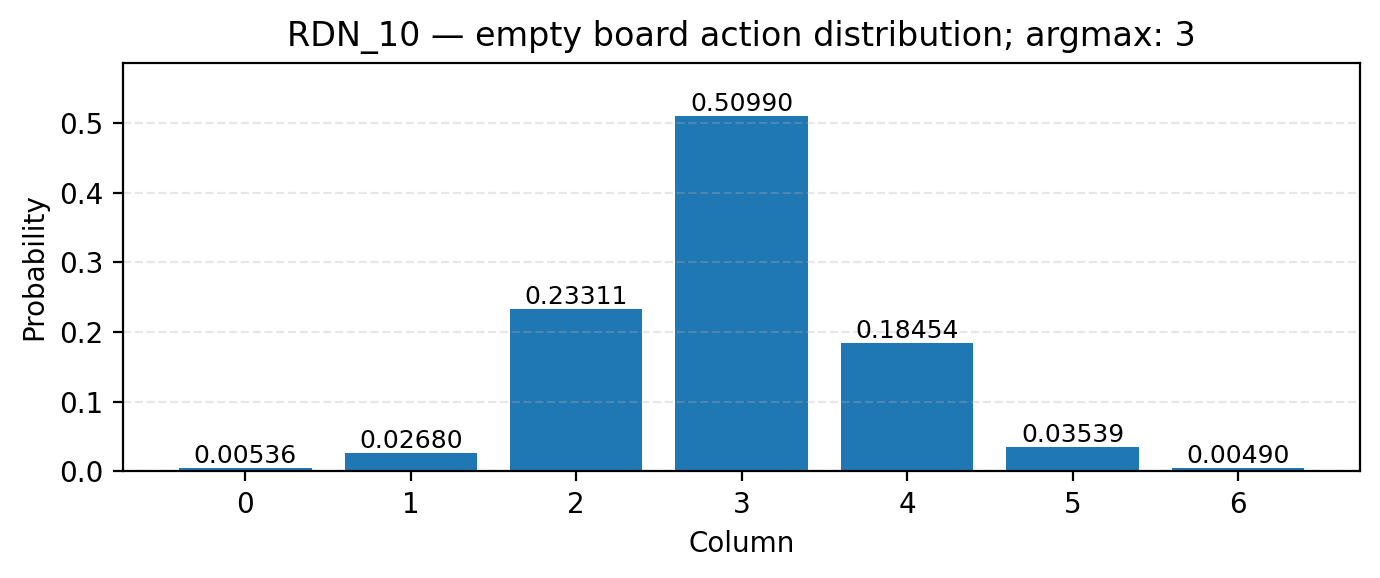

In [9]:
for P in hof.members.keys():
    counts = exploitation_histogram(hof.members[P].policy, n_states=256, rng_seed=666)
    eh = plot_exploitation_histogram(counts,  P)
    plt.show(eh)
    eba = plot_empty_board_action_distribution(hof.members[P].policy, tag=P)
    plt.show(eba)

# PPO

In [10]:
policy, resolved_path, meta = load_policy_simple(model_name, device=DEVICE, default_suffix=" PPO model.pt")
print(f"✅ Loaded: {resolved_path}")
if meta:
    epi = meta.get("episode", None)
    print(f"Meta — episode:{epi}  ts:{meta.get('timestamp','')}")
policy.eval(); 

✅ Loaded: RND_10 PPO model.pt
Meta — episode:800  ts:20251121-094049


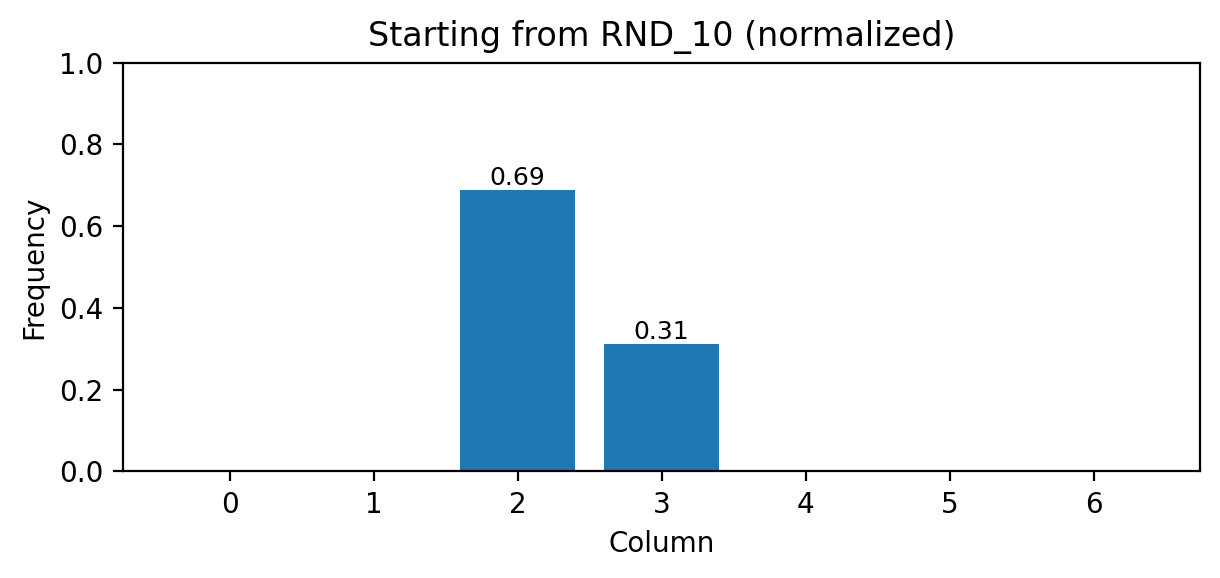

In [11]:
eh_pre = plot_exploitation_histogram(exploitation_histogram(policy, n_states=256, rng_seed=666),  f"Starting from {model_name}")
plt.show(eh_pre)

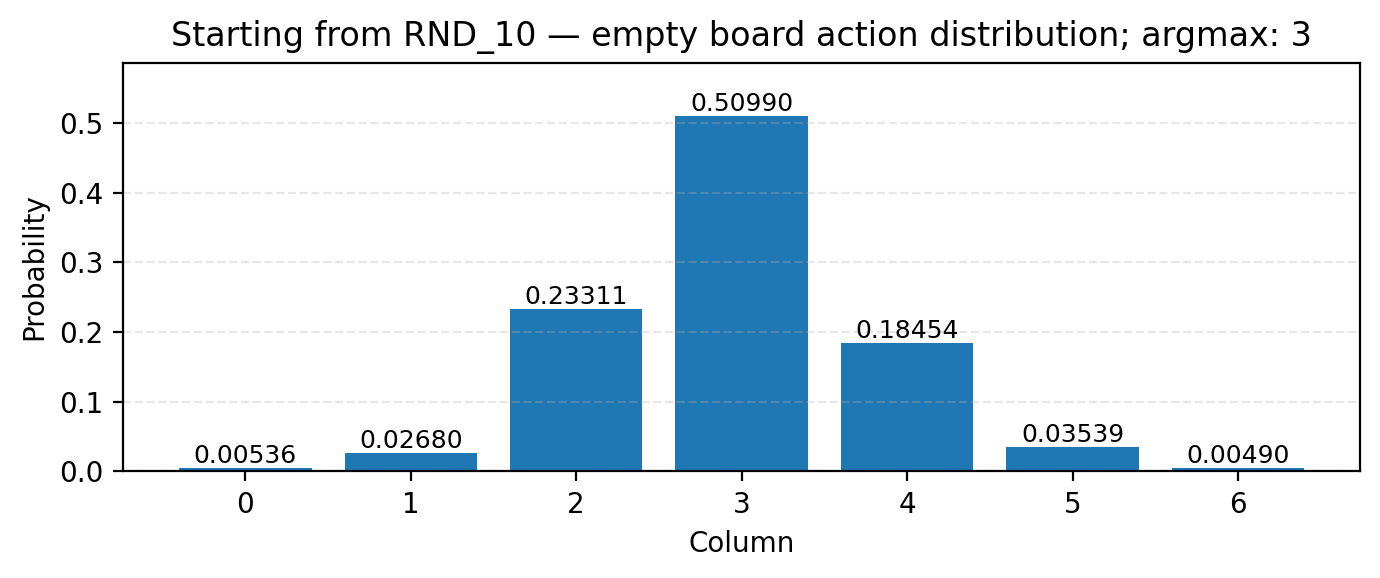

In [12]:
eba_pre = plot_empty_board_action_distribution(policy, f"Starting from {model_name}")
plt.show(eba_pre)

In [13]:
# ==== H2H inline metric config ====
H2H_ENABLED      = True
H2H_GAMES        = 200           # e.g., 150–250 ~ quick
H2H_SEED         = SEED

H2H_BASELINE_PATH = f"{TEMP_DIR}H2H_baseline.pt"
H2H_KEEP_TEMPS    = 100          # keep last N temp ckpts
h2h_history       = {"episode": [], "score": [], "lo": [], "hi": [], "n": []}
ensemble_h2h_history       = {"episode": [], "score": [], "lo": [], "hi": [], "n": []}
_h2h_temp_paths   = []
hth_best_score    = -1.0

# Save the baseline (B) once — the model as loaded *before* new training
save_checkpoint(
    policy=policy, optim=None,
    episode=0, 
    cfg=None, hparams=None,
    model_path=H2H_BASELINE_PATH,
    default_model_path=None
)
print(f"✅ H2H baseline saved to: {H2H_BASELINE_PATH}")

✅ H2H baseline saved to: Models/PPO/TEMP/H2H_baseline.pt


In [14]:
summary(policy, input_size=(1, 2, 6, 7))

Layer (type:depth-idx)                   Output Shape              Param #
ActorCritic                              [1, 7]                    --
├─C4DirectionalBackbone: 1-1             [1, 64, 2, 3]             --
│    └─Conv2d: 2-1                       [1, 16, 6, 6]             400
│    └─Conv2d: 2-2                       [1, 16, 5, 7]             400
│    └─Conv2d: 2-3                       [1, 16, 5, 6]             400
│    └─AvgPool2d: 2-4                    [1, 16, 5, 6]             --
│    └─AvgPool2d: 2-5                    [1, 16, 5, 6]             --
│    └─Conv2d: 2-6                       [1, 64, 5, 6]             27,712
│    └─ResidualBlock: 2-7                [1, 64, 5, 6]             --
│    │    └─Conv2d: 3-1                  [1, 64, 5, 6]             36,928
│    │    └─Conv2d: 3-2                  [1, 64, 5, 6]             36,928
│    └─MaxPool2d: 2-8                    [1, 64, 2, 3]             --
├─AdaptiveAvgPool2d: 1-2                 [1, 64, 1, 1]             --


## Seeding

In [15]:
DATA_FILES = [
   #"DATA/C4.play_data_BC_clean.xlsx",    # cleand to prund bad games, low rewards
    #"DATA/C4.play_data.xlsx"       #dedicated to L1 ... L3 h2H games
    "DATA/C4.L1L2L3_play_data.xlsx" 
]

frames = [pd.read_excel(f) for f in DATA_FILES]
DATA = pd.concat(frames, ignore_index=True)

BOARD_COLS = [f"{r}-{c}" for r in range(6) for c in range(7)]
DATA[BOARD_COLS] = DATA[BOARD_COLS].astype("int8")
DATA["reward"] = pd.to_numeric(DATA["reward"], errors="coerce")

print(f"✅ Loaded {len(DATA_FILES)} files, total rows: {len(DATA):,}")
display(DATA[["reward"]].describe())

✅ Loaded 1 files, total rows: 23,649


,reward
count,23649.000000
mean,133.944162
std,305.260744
min,-34.000000
25%,6.500000
50%,29.500000
75%,45.250000
max,1000.000000


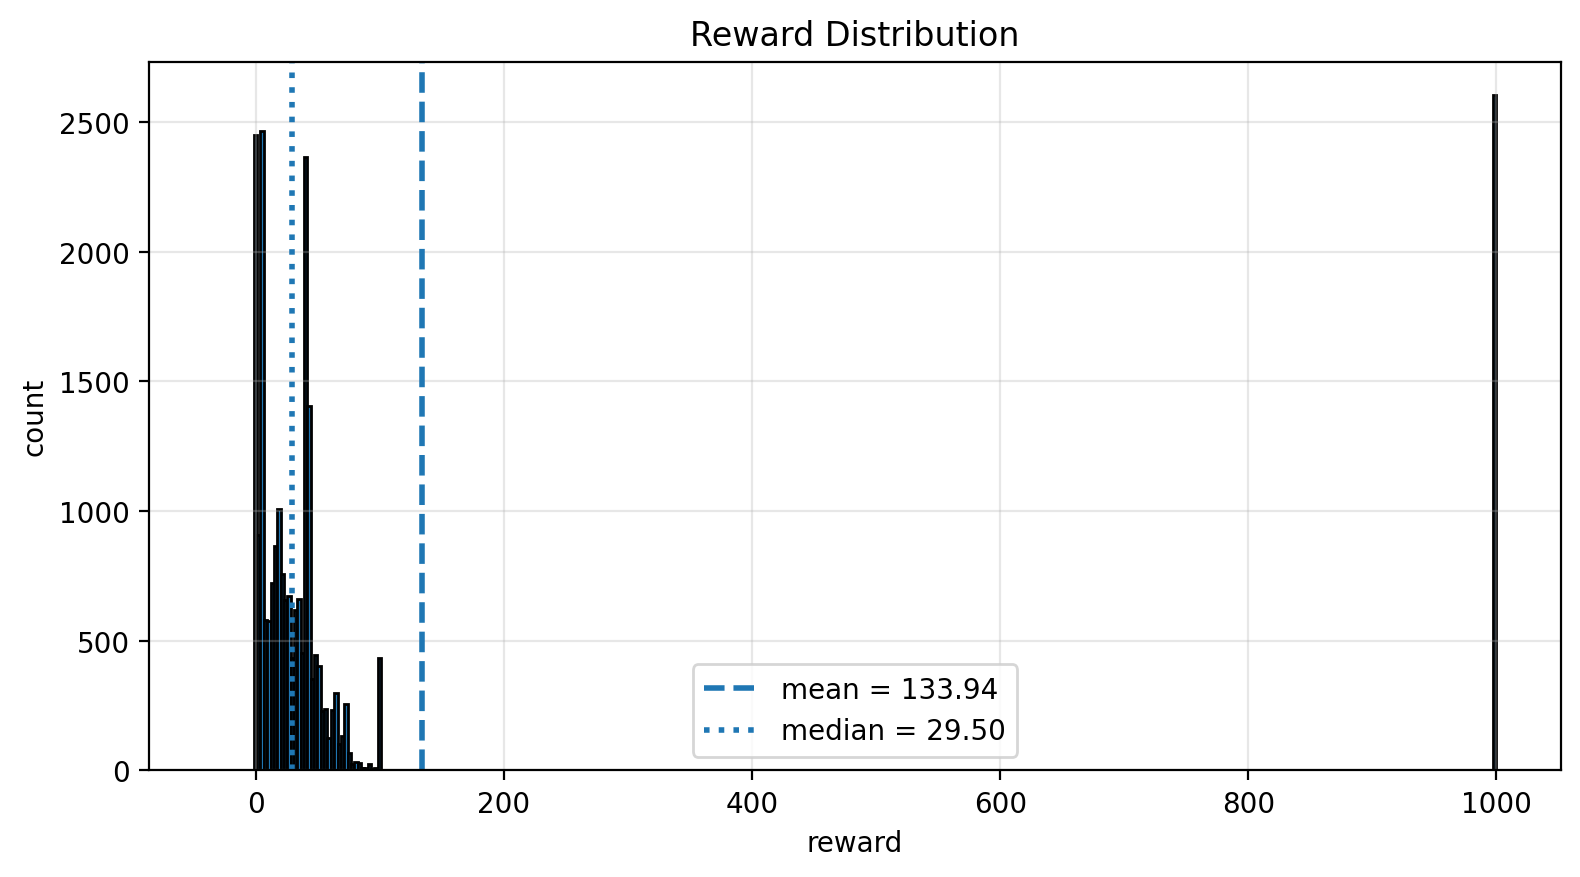

In [16]:
r = DATA["reward"].astype(float).dropna()
fig, ax = plt.subplots(figsize=(8,4.5))
bins = np.arange(r.min()-0.5, r.max()+1.5, 1) if np.allclose(r, r.round()) else "auto"
n, bins, _ = ax.hist(r, bins=bins, edgecolor="black")
ax.axvline(r.mean(),   ls="--", lw=2, label=f"mean = {r.mean():.2f}")
ax.axvline(r.median(), ls=":",  lw=2, label=f"median = {r.median():.2f}")
ax.set(title="Reward Distribution", xlabel="reward", ylabel="count")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

In [17]:
from PPO.ppo_bc_seed import bc_pretrain_actor
from PPO.ppo_bc_seed_adapters import iter_moves_for_bc

if SEED:
    begin_seed_time = time.time()
    
    bc_stats = bc_pretrain_actor(
        policy=policy,
        samples_iterable=iter_moves_for_bc(DATA, verbose=True),
        epochs = SEED_EPOCHS, 
        batch_size=4096,
        lr=5e-5, #lr=1e-4,
        ent_coef=0.02, #ent_coef=0.1,
        max_grad_norm=0.5,
        verbose=True,
    )
    
    end_seed_time = time.time()
    total_seeding = (end_seed_time - begin_seed_time)
    print(f"Seeding completed in {total_seeding:.1f} seconds")
    print("✅ BC warm-start complete.")
    policy.eval()

[BC-adapter] games=1586, samples_emitted=11457, skipped_games=602
  skipped (first 10): [('L1', 3), ('L1', 4), ('L1', 5), ('L1', 7), ('L1', 12), ('L1', 18), ('L10L12', 1), ('L10L12', 2), ('L10L12', 3), ('L10L12', 4)]


[BC] Epoch 0/16 | CE=---- | Ent=----:   0%|          | 0/16 [00:00<?, ?it/s]

[BC] Done in 9.3s | Samples: 11457
Seeding completed in 15.3 seconds
✅ BC warm-start complete.


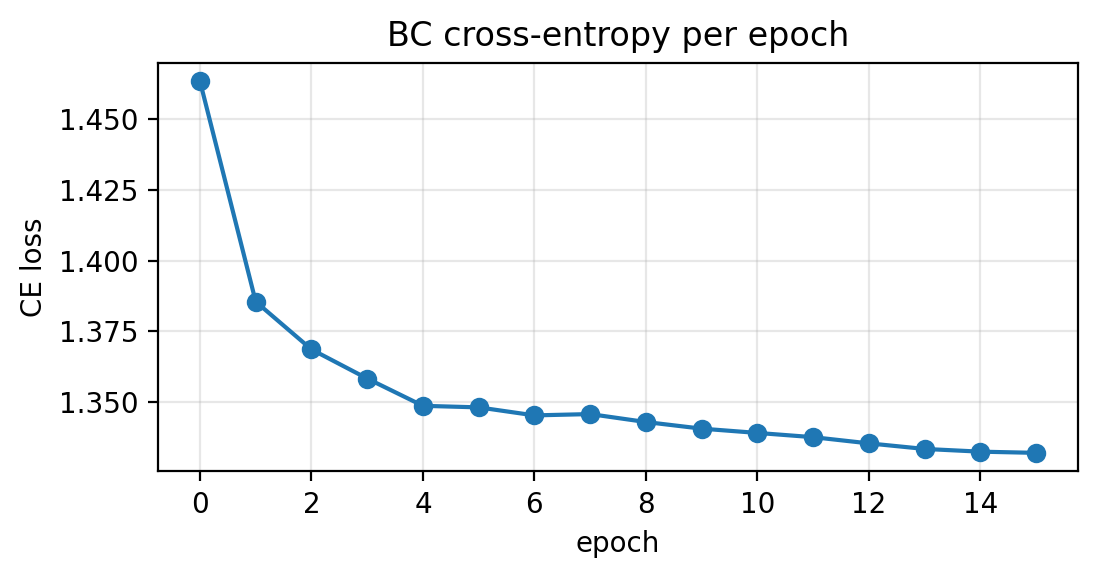

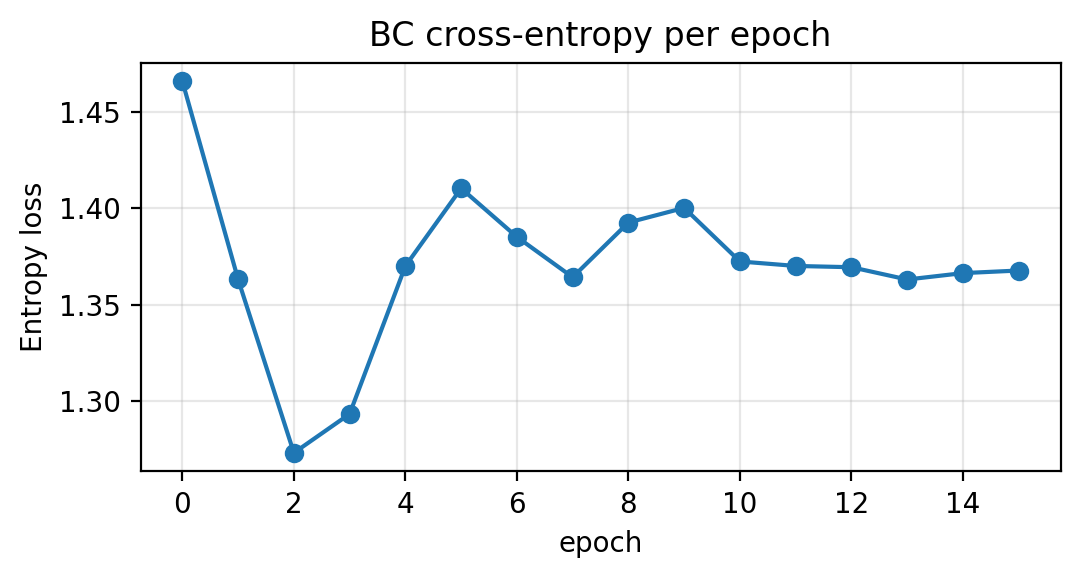

In [18]:
if SEED:
    if bc_stats["loss_ce"]:
        fig, ax = plt.subplots(figsize=(5.5, 3))
        ax.plot(bc_stats["loss_ce"], marker="o")
        ax.set_title("BC cross-entropy per epoch")
        ax.set_xlabel("epoch")
        ax.set_ylabel("CE loss")
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    if bc_stats["loss_ent"]:
        fig, ax = plt.subplots(figsize=(5.5, 3))
        ax.plot(bc_stats["loss_ent"], marker="o")
        ax.set_title("BC cross-entropy per epoch")
        ax.set_xlabel("epoch")
        ax.set_ylabel("Entropy loss")
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    


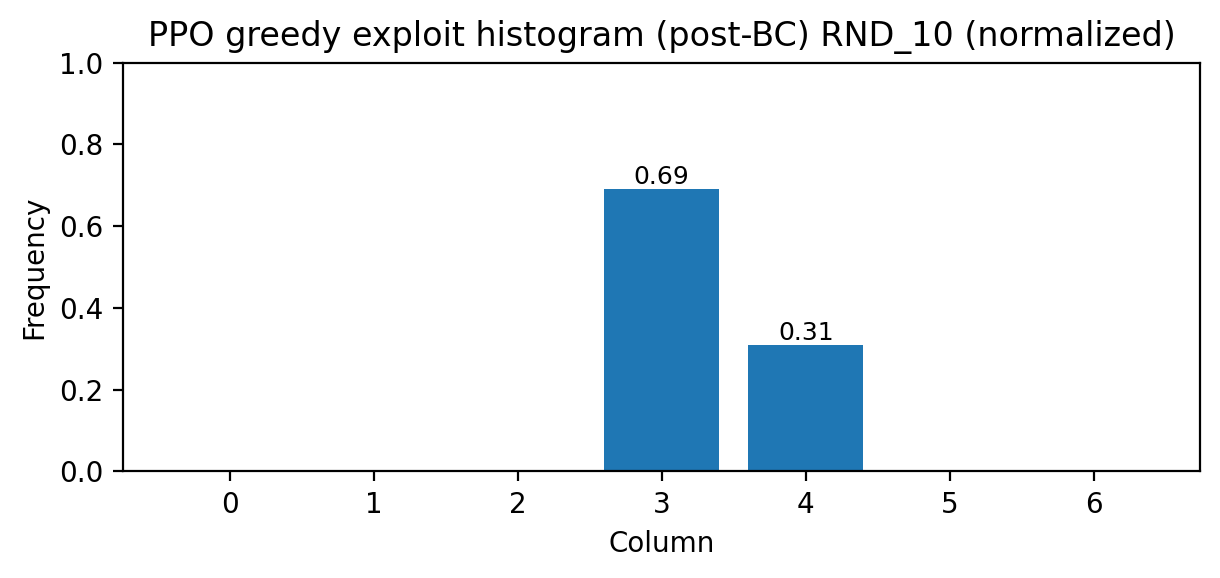

In [19]:
counts = exploitation_histogram(policy, n_states=256, rng_seed=0)
ehbc = plot_exploitation_histogram(counts, title=f"PPO greedy exploit histogram (post-BC) {model_name}")
plt.show(ehbc)

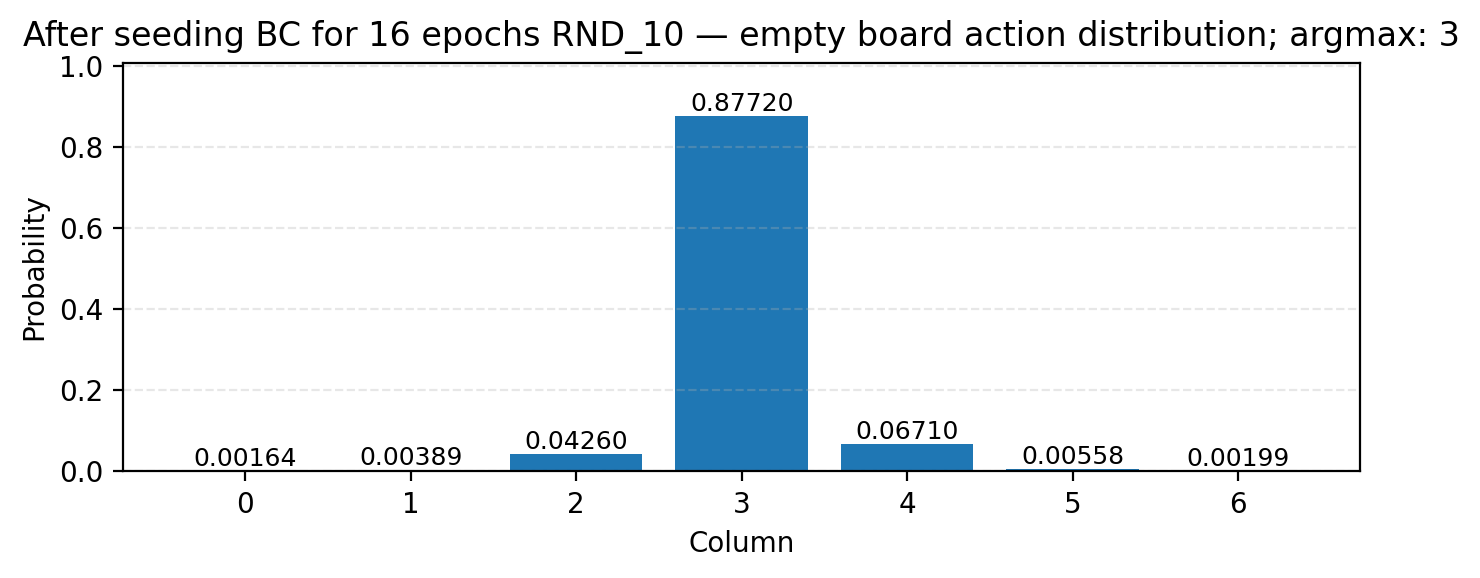

In [20]:
eba_bc = plot_empty_board_action_distribution(policy, f"After seeding BC for {SEED_EPOCHS} epochs {model_name}")
plt.show(eba_bc)

In [21]:
if SEED: torch.save(policy.state_dict(), f"{model_name}_PPO_BC-CENTER.pt")

In [22]:
# --- Logging / histories ---
win_history = []  

ppo_metrics_history = {
    "episodes": [],
    "loss_pi": [],
    "loss_v": [],
    "entropy": [],
    "approx_kl": [],
    "clip_frac": [],
    "explained_variance": [],
}

update_idx = 0
steps_collected = 0
reward_history = []              # per-episode total reward
benchmark_history  = None
wins = losses = draws = 0
win_count  = 0
loss_count = 0
draw_count = 0
win_history= []

# --- opponent overlay / logging helpers ---
opponent_timeline: list[str] = []   # one short key per episode -> drives the overlay
sampled_opponent_key: str | None = None
phase_mix: dict[str, float] = {"R": 1.0}  # default shown in logs (no effect yet)


In [23]:
# hard defaults
STEPS_PER_UPDATE    = 8192           # agent decisions per PPO update
LEARNING_RATE       = 3e-4
TEMPERATURE         = 1.0            # 0.0 = greedy sampling
ATTR_LOSS_TO_LAST   = True           # attribute opponent's terminal win to our last move
CLEAR_BUFFER_ON_PHASE_CHANGE = True  # avoid leaking rollouts across phases
BENCHMARK_EVERY     = 25
H2H_EVERY           = BENCHMARK_EVERY 
AUG_MULT            = 4
REWARD_SCALE        = 0.01

# --- Env / Policy / Optimizer / Buffer ---
env     = Connect4Env()
optim   = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE, eps=1e-5)

hparams = PPOHyperParams(gamma=0.99, gae_lambda=0.95, normalize_adv=True)
buffer  = PPOBuffer(capacity=STEPS_PER_UPDATE * AUG_MULT, action_dim=7, hparams=hparams)

cfg     = PPOUpdateCfg(
                epochs=4, 
                batch_size=512,
                clip_range=0.20, 
                vf_clip_range=0.20,
                ent_coef=0.01, 
                vf_coef=0.5,
                max_grad_norm=0.5, 
                target_kl=0.03,
                distill_coef=0.0
            )

opening_kpis = init_opening_kpis(cols=7)          
openings = OpeningTracker(cols=7, log_every=plot_interval, ma_window=12)

### Live plot

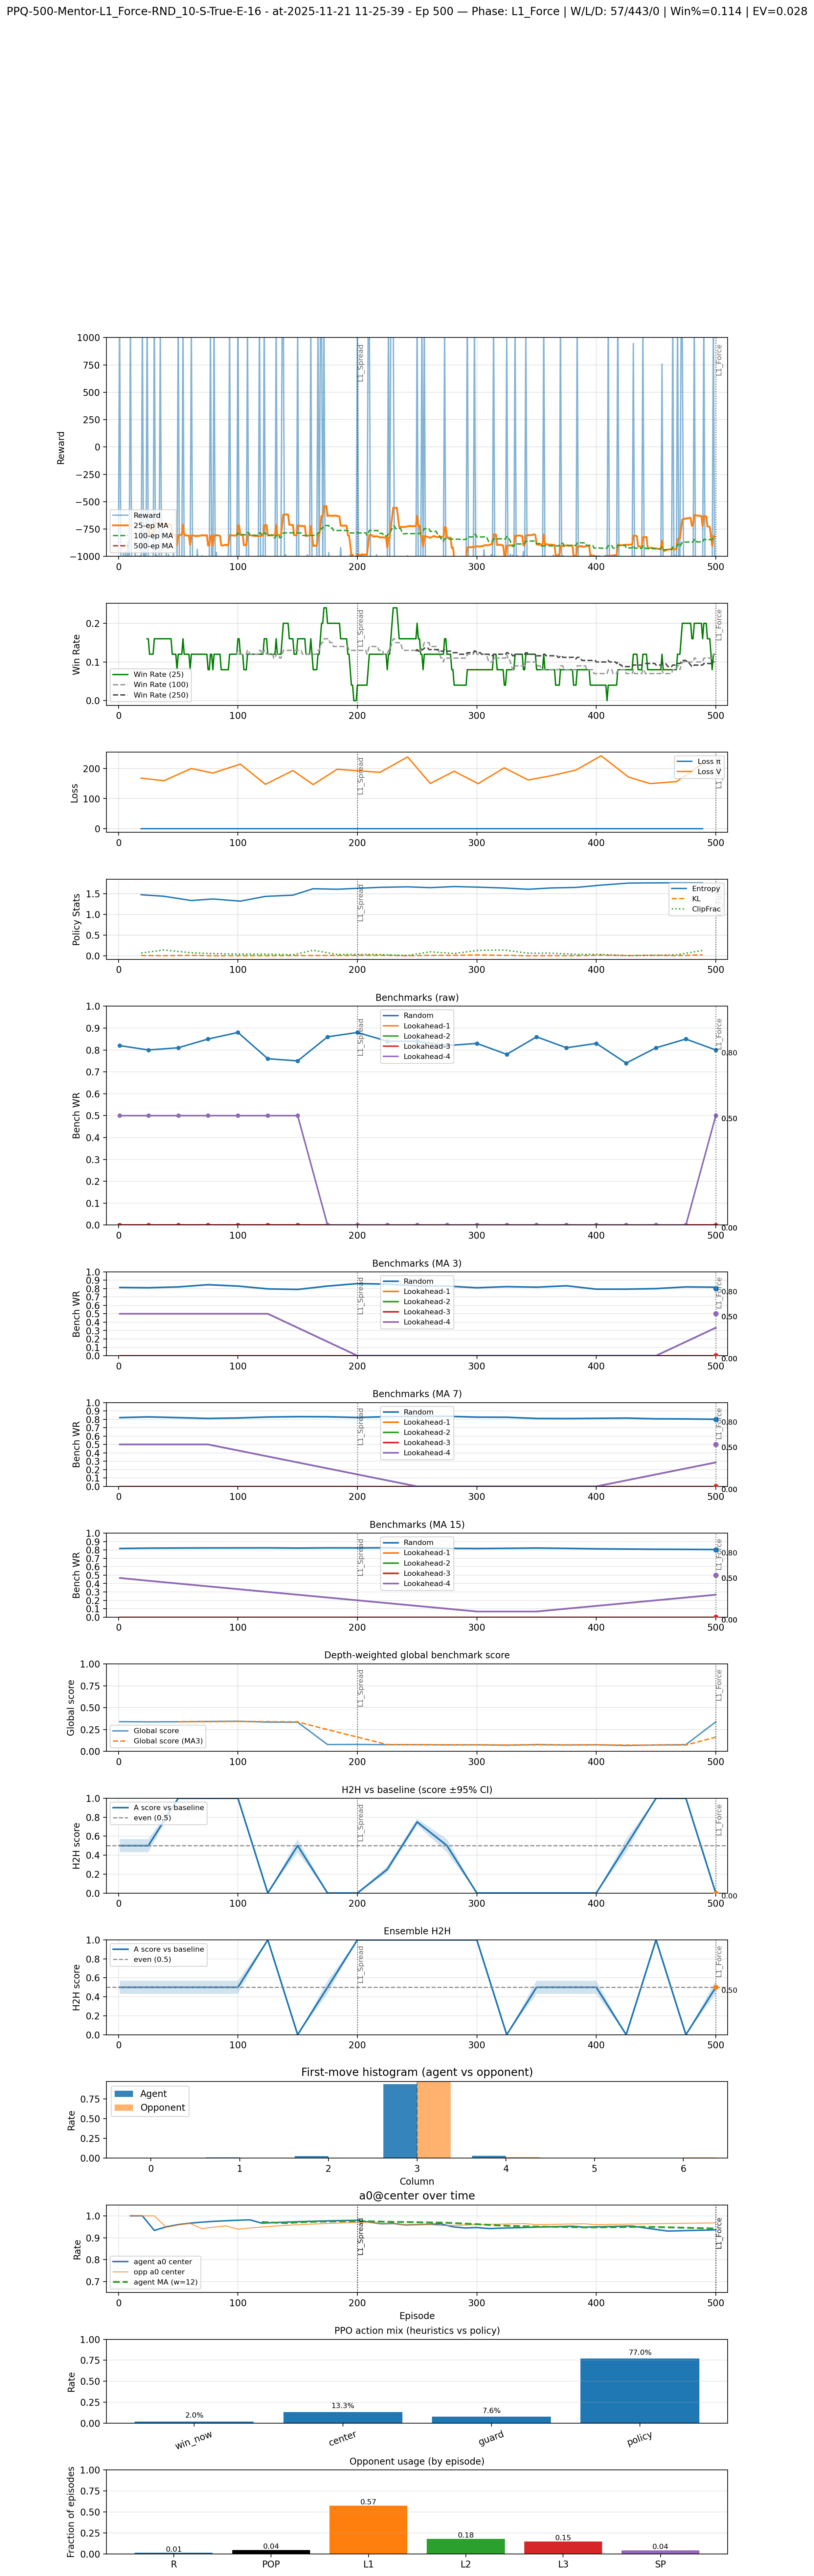

In [24]:
plots_handle = display(None, display_id=True)   
fig = None 

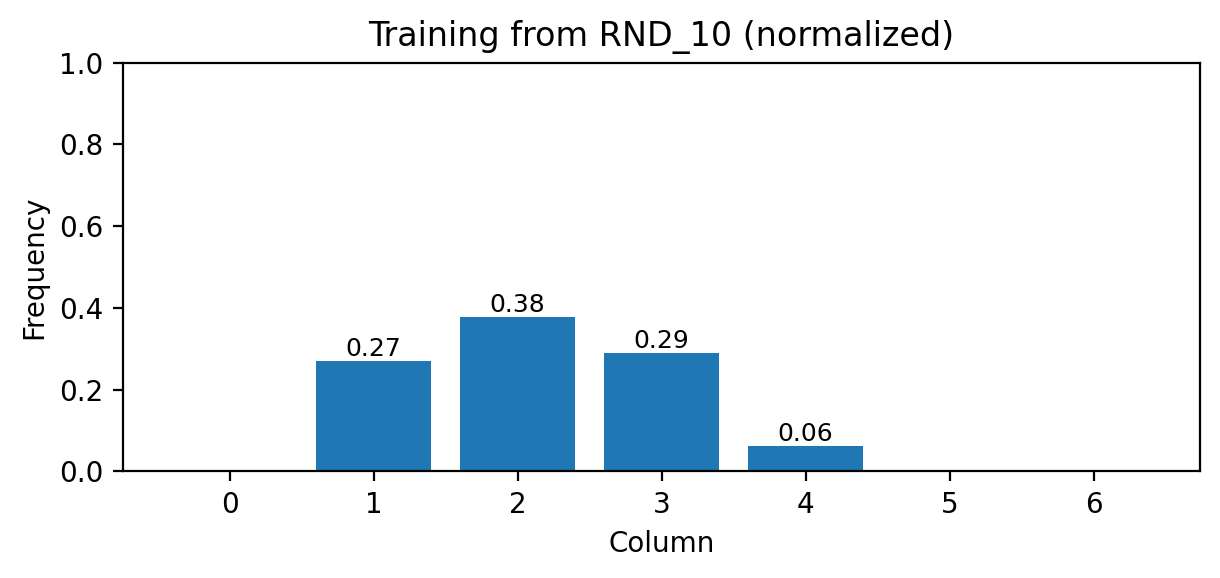

In [25]:
eh_handle = display(None, display_id=True)   
EH = None

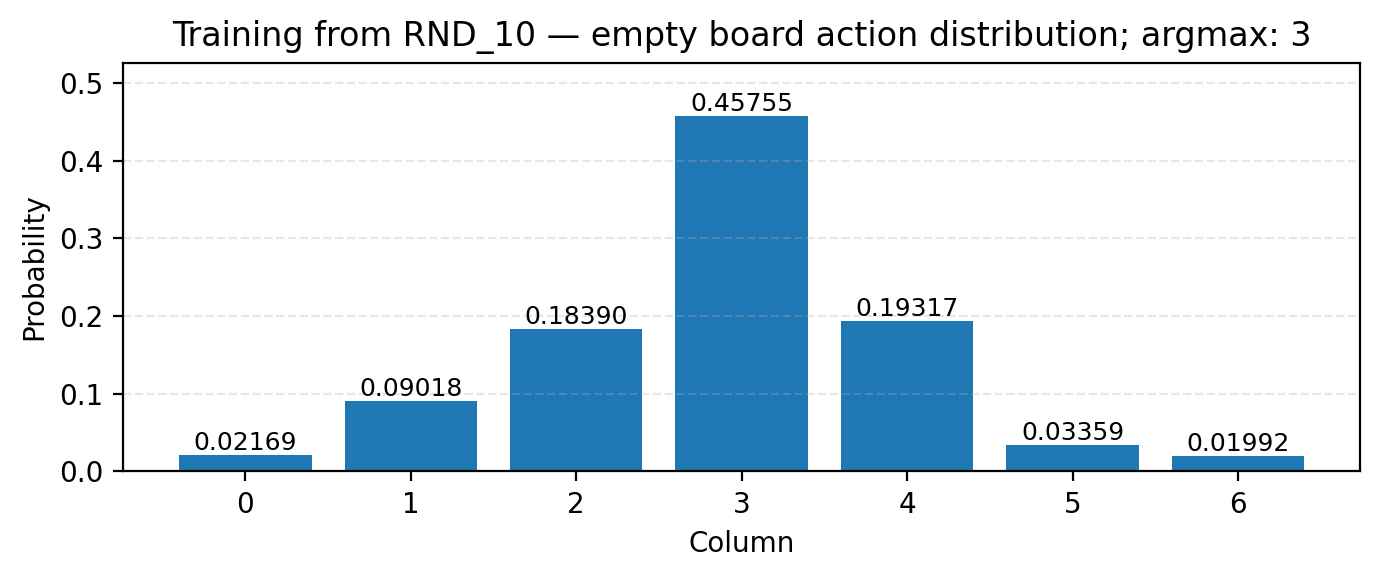

In [26]:
eba_handle = display(None, display_id=True)   
EBA = None

## Training Loop

In [27]:
# ============================
# PPO TRAINING LOOP 
# ============================

# temp state
steps_collected = 0
update_idx = 0
current_phase_name = None
last_agent_reward_entries_ref = [None]  # 1-slot box mutated in helpers
current_mentor = None

# phase-aware temperature (mutated in-place)
temperature_ref = {"T": 1.0}
recompute_fn = make_recompute_lp_val(policy, DEVICE, temperature_ref)

start_time = time.time()

with tqdm(total=number_episodes, desc="Episodes", leave=True, dynamic_ncols=True) as epbar:
    opponent_sampler = None

    for episode in range(1, number_episodes + 1):
        # --- curriculum phase ---
        phase_info, changed = PHASES.start_episode(episode)
        current_phase_name = phase_info.name

        if changed:
            # ---- apply phase params ----
            p = params_for_phase(current_phase_name, cfg)

            if p["mentor_prob"] > 0.0 and p["mentor_coef"] > 0.0:
                current_mentor = LookaheadMentor(depth=p["mentor_prob"], device=DEVICE)
            else:
                current_mentor = None

            # optimizer LR
            for g in optim.param_groups:
                g["lr"] = p["lr"]

            # PPO update cfg
            cfg.clip_range    = p["clip"]
            cfg.ent_coef      = p["entropy"]
            cfg.epochs        = p["epochs"]
            cfg.target_kl     = p["target_kl"]
            cfg.vf_coef       = p["vf_coef"]
            cfg.vf_clip_range = p["vf_clip"]
            cfg.batch_size    = p["batch_size"]
            cfg.max_grad_norm = p["max_grad_norm"]
            temperature_ref["T"] = p["temperature"]
            cfg.mentor_depth = p["mentor_depth"]
            cfg.mentor_prob  = p["mentor_prob"]
            cfg.mentor_coef  = p["mentor_coef"]


            # --- heuristic knobs (phase dependent) ---
            policy.set_phase_heuristics(
                center_start=p["center_start"],
                guard_prob=p["guard_prob"],
                win_now_prob=p["win_now_prob"],
                guard_ply_min=p["guard_ply_min"],
                guard_ply_max=p["guard_ply_max"],
            )

            # rollout size change
            new_spu = p.get("steps_per_update", STEPS_PER_UPDATE)
            if new_spu != STEPS_PER_UPDATE:
                STEPS_PER_UPDATE = new_spu
                buffer = PPOBuffer(
                    capacity=STEPS_PER_UPDATE * AUG_MULT + 512,
                    action_dim=7,
                    hparams=hparams,
                    reward_scale=REWARD_SCALE,
                )
                steps_collected = 0
                last_agent_reward_entries_ref[0] = None

            if CLEAR_BUFFER_ON_PHASE_CHANGE:
                buffer.clear()
                steps_collected = 0
                last_agent_reward_entries_ref[0] = None

            # opponent sampler for this phase
            phase_mix_cfg = TRAINING_PHASES[current_phase_name].get("opponent_mix", None)
            phase_mix = {str(k): float(v) for k, v in (phase_mix_cfg or {"R": 1.0}).items()}
            opponent_sampler = OpponentSampler(phase_mix, seed=episode)

            # ---- phase checkpoint (once per phase) ----
            phase_ckpt = f"{MODEL_DIR}{TRAINING_SESSION}_phase_{current_phase_name}_ep{episode}.pt"
            save_checkpoint(
                policy=policy, optim=optim,
                episode=episode,
                cfg=cfg, hparams=hparams,
                model_path=phase_ckpt,
                default_model_path=None
            )

        # choose opponent for THIS episode
        sampled_key = opponent_sampler.sample_key()
        lookahead_mode = OpponentSampler.key_to_mode(sampled_key)
        opponent_timeline.append(sampled_key)

        # POP opponent uses hall-of-fame ensemble instead of student
        is_pop = (lookahead_mode == "POP")

        if is_pop:
            opp_policy = pop_ensemble_policy    # frozen ensemble
            opp_mode   = "self"                 # reuse self-play branch in helpers
        else:
            opp_policy = policy                 # current student
            opp_mode   = lookahead_mode

        # ------------- episode init -------------
        env.reset()
        ep_return = 0.0                    # sum of shaped rewards (debug only)
        total_reward = 0.0                 # terminal mapped reward (WIN/DRAW/LOSS)
        final_result = None                # 1 win, -1 loss, 0.5 draw
        last_agent_reward_entries_ref[0] = None
        ply_idx = 0
        policy.center_forced_used = False

        # alternating start: maybe opponent opens (keep parity with DQN: use episode-1)
        done, ply_idx, penalty = ppo_maybe_opponent_opening(
            env=env,
            policy=opp_policy,             # <--- ensemble if POP
            episode=episode - 1,
            lookahead_mode=opp_mode,       # "self" if POP, else original mode
            temperature=temperature_ref["T"],
            buffer=buffer,
            last_agent_reward_entries_ref=last_agent_reward_entries_ref,
            loss_penalty=Connect4Env.LOSS_PENALTY,
            opening_kpis=opening_kpis,
            openings=openings,
            attr_loss_to_last=ATTR_LOSS_TO_LAST,
        )
        ep_return += penalty

        # ================= EPISODE LOOP =================
        while not env.done:
            # --- Agent move (+1) ---
            done, r_agent, ply_idx = ppo_agent_step(
                env=env,
                policy=policy,
                buffer=buffer,
                temperature=temperature_ref["T"],
                recompute_fn=recompute_fn,
                last_agent_reward_entries_ref=last_agent_reward_entries_ref,
                ply_idx=ply_idx,
                opening_kpis=opening_kpis,
                openings=openings,
            )
            ep_return += r_agent
            steps_collected += 1

            if done:
                _, final_result, total_reward = ppo_finalize_if_done(env)
                break
            
            # --- Opponent (-1) responds ---
            done, ply_idx, penalty = ppo_opponent_step(
                env=env,
                policy=opp_policy,
                lookahead_mode=lookahead_mode,
                temperature=temperature_ref["T"],
                buffer=buffer,
                last_agent_reward_entries_ref=last_agent_reward_entries_ref,
                loss_penalty=Connect4Env.LOSS_PENALTY,
                ply_idx=ply_idx,
                opening_kpis=opening_kpis,
                openings=openings,
                attr_loss_to_last=ATTR_LOSS_TO_LAST,
            )

            ep_return += penalty # penalty is negative

            if done:
                _, final_result, total_reward = ppo_finalize_if_done(env)
                break

            # ===== PPO UPDATE GATE (after agent decisions) =====
            if steps_collected >= STEPS_PER_UPDATE:
                # bootstrap value if non-terminal and agent to move
                last_done = not (env.current_player == +1 and not env.done)
                last_value = 0.0
                if not last_done:
                    with torch.no_grad():
                        enc_boot = encode_two_channel_agent_centric(env.board, +1)
                        inp = torch.from_numpy(enc_boot).unsqueeze(0).to(DEVICE).float()
                        _, v_boot = policy.forward(inp)
                        last_value = float(v_boot.squeeze().item())

                buffer.compute_gae(last_value=last_value, last_done=last_done)
                metrics = ppo_update(policy, optim, buffer, cfg, pop_ensemble_policy, current_mentor)

                # ---- record metrics per update ----
                ppo_metrics_history["episodes"].append(episode)
                ppo_metrics_history["loss_pi"].append(float(metrics.get("loss_pi", 0.0)))
                ppo_metrics_history["loss_v"].append(float(metrics.get("loss_v", 0.0)))
                ppo_metrics_history["entropy"].append(float(metrics.get("entropy", 0.0)))
                ppo_metrics_history["approx_kl"].append(float(metrics.get("approx_kl", 0.0)))
                ppo_metrics_history["clip_frac"].append(float(metrics.get("clip_frac", 0.0)))
                ppo_metrics_history["explained_variance"].append(float(metrics.get("explained_variance", 0.0)))

                buffer.clear()
                steps_collected = 0
                last_agent_reward_entries_ref[0] = None
                update_idx += 1

        # ============ EPISODE END ============

        # Win/loss/draw counters
        wins, losses, draws = track_result(final_result, win_history)
        win_count += wins
        loss_count += losses
        draw_count += draws

        reward_history.append(ep_return)
        openings.maybe_log(episode + 1)
        epbar.update(1)

        # --- periodic head-to-head vs baseline (inline) ---
        if H2H_ENABLED and ((episode % H2H_EVERY) == 0 or episode == 1):
            tmp_path = f"{TEMP_DIR}{TRAINING_SESSION}_H2H_tmp_ep{episode}.pt"
            save_checkpoint(policy=policy, optim=optim, episode=episode, cfg=cfg, hparams=hparams, model_path=tmp_path, default_model_path=None)
            _h2h_temp_paths.append(tmp_path)

            # trim old temps
            while len(_h2h_temp_paths) > H2H_KEEP_TEMPS:
                old = _h2h_temp_paths.pop(0)
                try: os.remove(old)
                except Exception: pass

            # A (current) vs B (baseline)
            res = head_to_head(
                ckptA=tmp_path,
                ckptB=H2H_BASELINE_PATH,
                n_games=H2H_GAMES,
                device=DEVICE,
                opening_noise_k=0,
                seed=H2H_SEED,
                progress=False,
            )

            score = float(res["A_score_rate"])
            if episode > 50 and score >= hth_best_score:
                hth_best_score = score
                best_path = f"{TEMP_DIR}H2H_best_score({score:.3f})_ep{episode}.pt"
                save_checkpoint(
                    policy=policy, optim=optim,
                    episode=episode,
                    cfg=cfg, hparams=hparams,
                    model_path=best_path,
                    default_model_path=None,
                )

            h2h_append(h2h_history, episode, res)

            #H2H vs ensemble
            res_pop = head_to_head_models(
                policy,
                pop_ensemble_policy,
                n_games=H2H_GAMES,
                A_label="Student",
                B_label="POP_ensemble",
                opening_noise_k=0,
                seed=H2H_SEED,
                progress=False,
            )
            ensemble_score = float(res_pop["A_score_rate"])
            h2h_append(ensemble_h2h_history, episode, res_pop)

        # --- inline benchmark
        if (episode % BENCHMARK_EVERY) == 0 or episode == 1:
            benchmark_history = update_benchmark_winrates(
                agent=policy,
                env=env,
                device=DEVICE,
                Lookahead=Connect4Lookahead,
                episode=episode,
                history=benchmark_history,
                save=f"{LOG_DIR}{TRAINING_SESSION}-benchmark.xlsx",
                score = score,
                ensemble_score = ensemble_score
            )

        # --- live plot ---
        if (episode % plot_interval) == 0:
            fig = plot_live_training_ppo(
                episode=episode,
                reward_history=reward_history,
                win_history=win_history,
                phase_name=current_phase_name,
                win_count=win_count,
                loss_count=loss_count,
                draw_count=draw_count,
                metrics_history=ppo_metrics_history,
                benchmark_history=benchmark_history,
                title=TRAINING_SESSION,
                phases=TRAINING_PHASES,
                save=False,
                save_path=PLOTS,
                opponent_timeline=opponent_timeline,
                overlay_last=100,
                h2h_history=h2h_history,
                ensemble_h2h_history = ensemble_h2h_history,
                openings=openings, 
                policy=policy,
            )

            if fig is not None:
                plots_handle.update(fig)   
                plt.close(fig)

            # histograms
            cnt = exploitation_histogram(policy, n_states=256, rng_seed=666)
            EH = plot_exploitation_histogram(cnt, f"Training from {model_name}")
            if EH is not None:
                eh_handle.update(EH)   
                plt.close(EH)

            EBA = plot_empty_board_action_distribution(policy, f"Training from {model_name}")
            if EBA is not None:
                eba_handle.update(EBA)   
                plt.close(EBA)

print(f"Training finished in {(time.time() - start_time)/60:.1f} min")


Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Opponent: Random:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/50 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/30 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/20 [00:00<?, ?it/s]

Training finished in 9.8 min


In [28]:
summarize_opening_kpis(opening_kpis)

{'a0_center_rate': 0.936, 'o0_center_rate': 0.968, 'a0_mode': 3, 'o0_mode': 3}

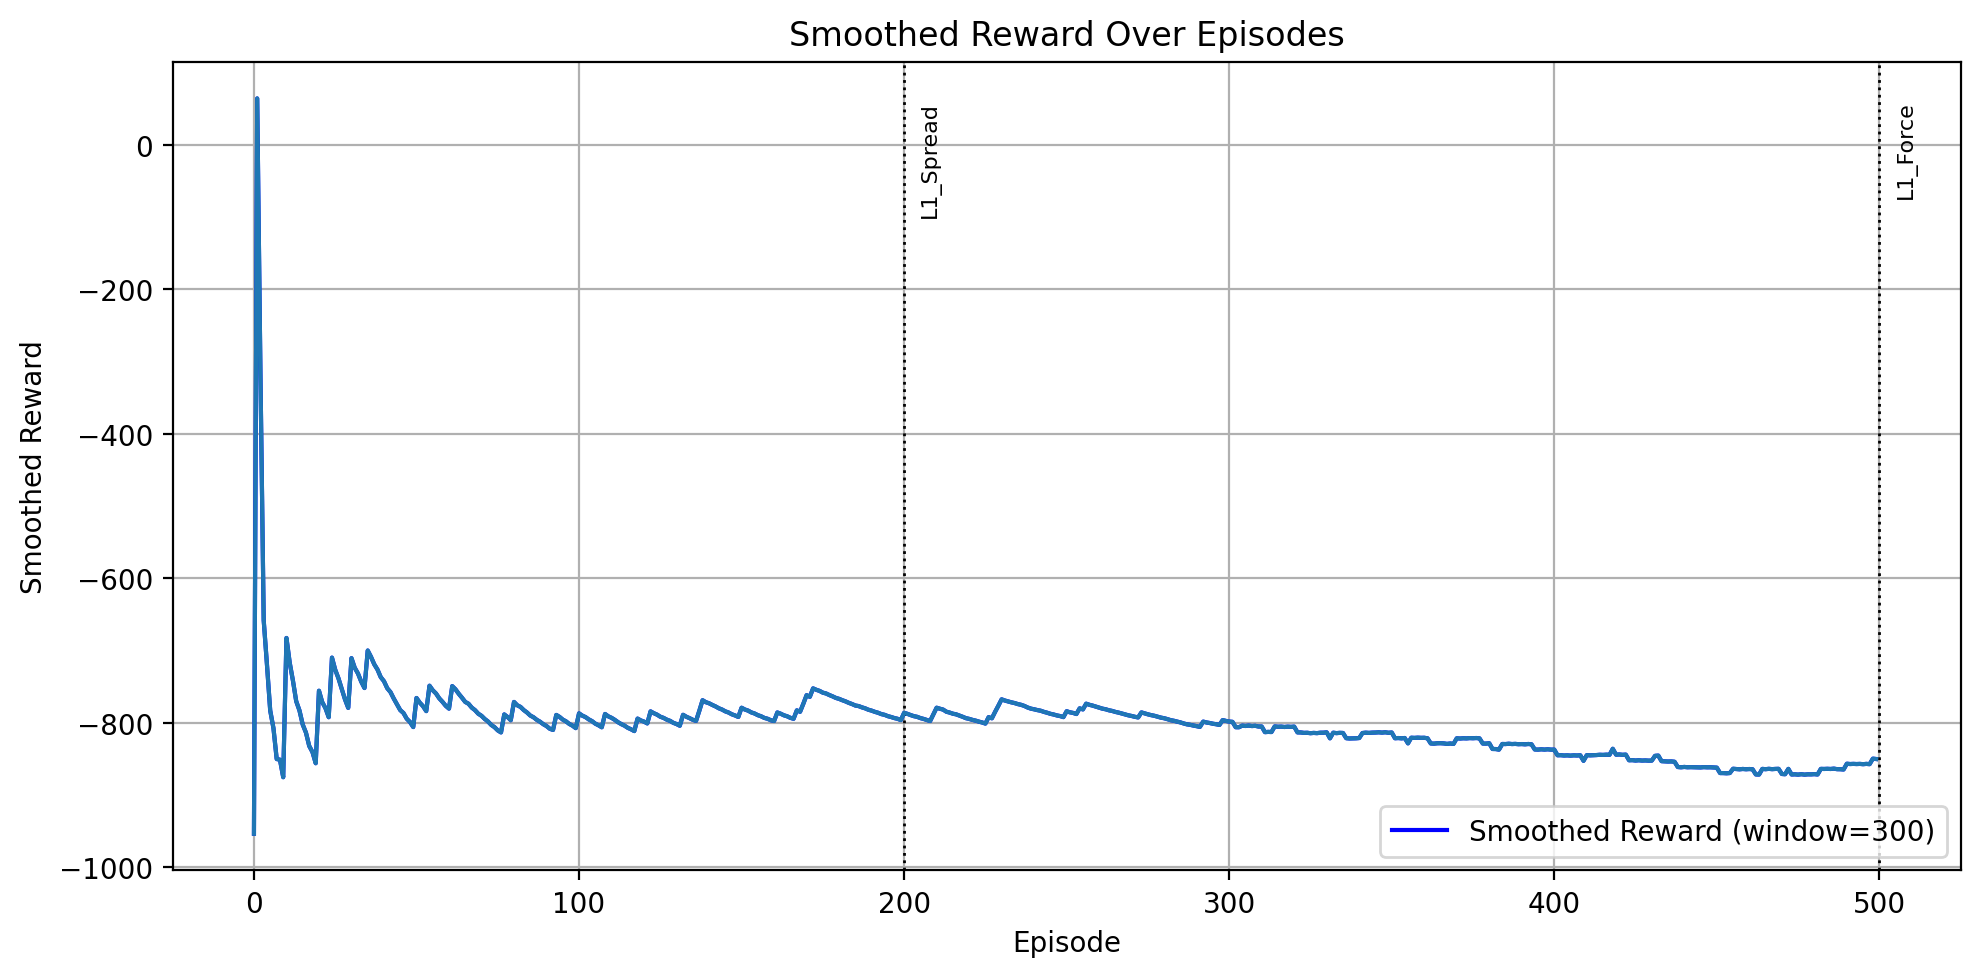

In [29]:
window = 300
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]

final_reward_fig, final_reward_ax = plt.subplots(figsize=(10, 5))
final_reward_ax.plot(smoothed, label=f"Smoothed Reward (window={window})", color='blue')

# --- Add phase transitions ---
for name, meta in TRAINING_PHASES.items():
    ep = meta["length"]
    if ep is not None and ep <= len(reward_history):
        final_reward_ax.axvline(x=ep, color='black', linestyle='dotted', linewidth=1)
        final_reward_ax.text(ep + 5, max(smoothed) * 0.95, name, rotation=90, va='top', ha='left', fontsize=8)

final_reward_ax.set_title("Smoothed Reward Over Episodes")
final_reward_ax.set_xlabel("Episode")
final_reward_ax.set_ylabel("Smoothed Reward")
final_reward_ax.legend()
final_reward_ax.grid(True)
final_reward_fig.tight_layout()

plt.plot(smoothed)
plt.show()

In [30]:
 fig = plot_live_training_ppo(
                episode=episode,
                reward_history=reward_history,
                win_history=win_history,
                phase_name=current_phase_name,
                win_count=win_count,
                loss_count=loss_count,
                draw_count=draw_count,
                metrics_history=ppo_metrics_history,
                benchmark_history=benchmark_history,
                title=TRAINING_SESSION,
                phases=TRAINING_PHASES,
                save=True,
                save_path=PLOTS,
                opponent_timeline=opponent_timeline,
                overlay_last=100,
                h2h_history=h2h_history,
                ensemble_h2h_history = ensemble_h2h_history,
                openings=openings, 
                policy=policy,
            )
plt.close(fig)

[Saved] Plots/PPO/PPQ-500-Mentor-L1_Force-RND_10-S-True-E-16 - at-2025-11-21 11-25-39__complete_training_plot.png


### Post training

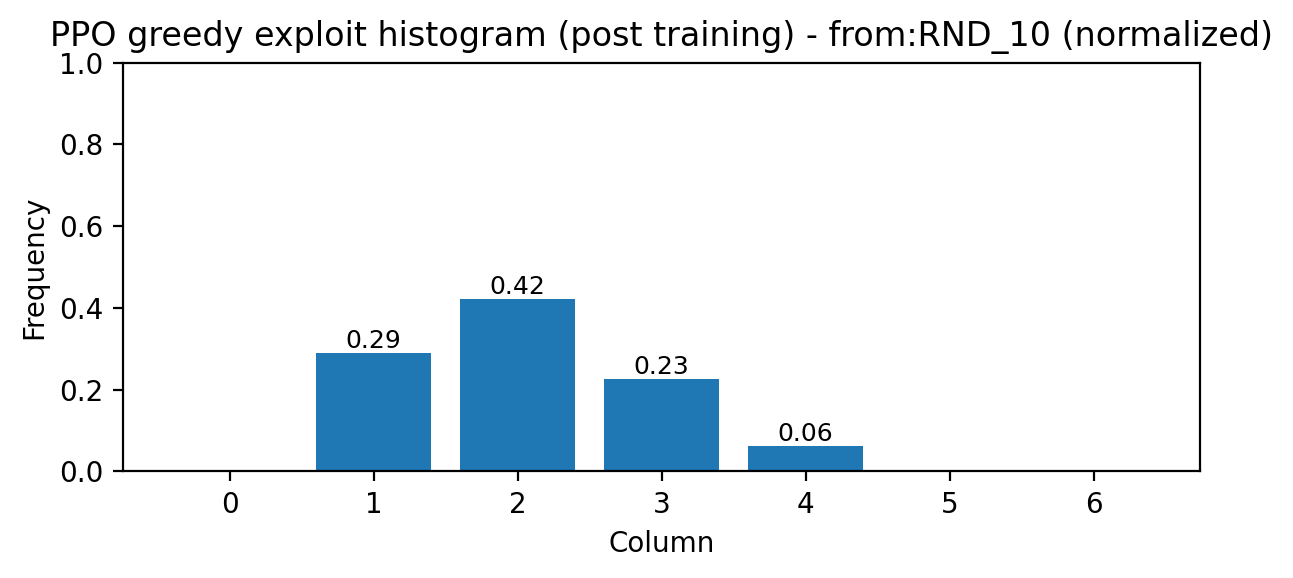

In [31]:
counts = exploitation_histogram(policy, n_states=256, rng_seed=0)
posteh = plot_exploitation_histogram(counts, title=f"PPO greedy exploit histogram (post training) - from:{model_name}")
plt.show(posteh)

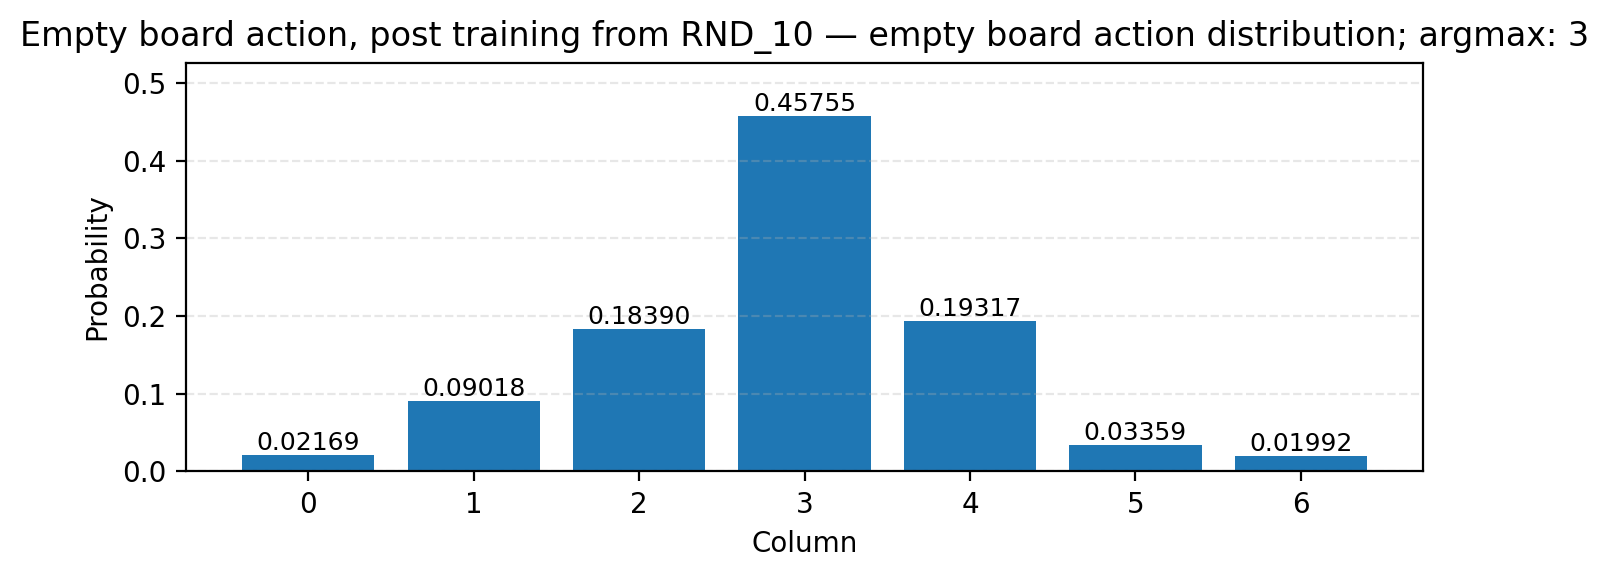

In [32]:
eba = plot_empty_board_action_distribution(policy,f"Empty board action, post training from {model_name}")
plt.show(eba)

## Save model

In [33]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 ppo_model_{timestamp} episodes-{number_episodes}.pt"
default_model_path = "Connect4 PPQ model.pt"   

model_path, default_model_path = save_checkpoint(
    policy=policy,
    optim=optim,
    episode=episode,
    cfg=cfg,
    hparams=hparams,
    model_path=model_path,
    default_model_path=default_model_path,
)
print(f"Model saved to {model_path}\nAlso wrote: {default_model_path}")

Model saved to Models/PPO/PPQ-500-Mentor-L1_Force-RND_10-S-True-E-16 - at-2025-11-21 11-25-39_Connect4 ppo_model_20251121-113609 episodes-500.pt
Also wrote: Connect4 PPQ model.pt


# Evaluation

In [34]:
EXCEL_OUT = "EVAL_PPO_results.xlsx"
t0 = time.time()
evaluation_results = evaluate_actor_critic_model(policy, EVALUATION_OPPONENTS, seed=SEED)
elapsed_h = (time.time() - t0) / 3600.0
row = results_to_row(run_tag=TRAINING_SESSION, results=evaluation_results, elapsed_h=elapsed_h, episodes=meta.get("episode"))
display(row)
append_eval_row_to_excel(row, EXCEL_OUT)
print("Saved to:", EXCEL_OUT)

Opponent: Random:   0%|          | 0/200 [00:00<?, ?it/s]

Opponent: Lookahead-1:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-2:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-3:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-4:   0%|          | 0/100 [00:00<?, ?it/s]

Opponent: Lookahead-5:   0%|          | 0/50 [00:00<?, ?it/s]

,TIME [h],EPISODES,Random,Lookahead-1,Lookahead-2,Lookahead-3,Lookahead-4,Lookahead-5
TRAINING_SESSION,,,,,,,,
PPQ-500-Mentor-L1_Force-RND_10-S-True-E-16 - at-2025-11-21 11-25-39,0.002168,None,0.74,0.0,0.5,0.0,0.5,0.0


Saved to: EVAL_PPO_results.xlsx


C:\Users\Uporabnik\Documents\JS\Connect4\Code\Jupiter\Connect4\PPO\ppo_agent_eval.py:238: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new = pd.concat([old, df_row.reset_index()], ignore_index=True)


📊 Evaluation Summary:
     Random: 148W / 52L / 0D → Win 74.0% | Loss 26.0% | Draw 0.0%
Lookahead-1: 0W / 100L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%
Lookahead-2: 50W / 50L / 0D → Win 50.0% | Loss 50.0% | Draw 0.0%
Lookahead-3: 0W / 100L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%
Lookahead-4: 50W / 50L / 0D → Win 50.0% | Loss 50.0% | Draw 0.0%
Lookahead-5: 0W / 50L / 0D → Win 0.0% | Loss 100.0% | Draw 0.0%


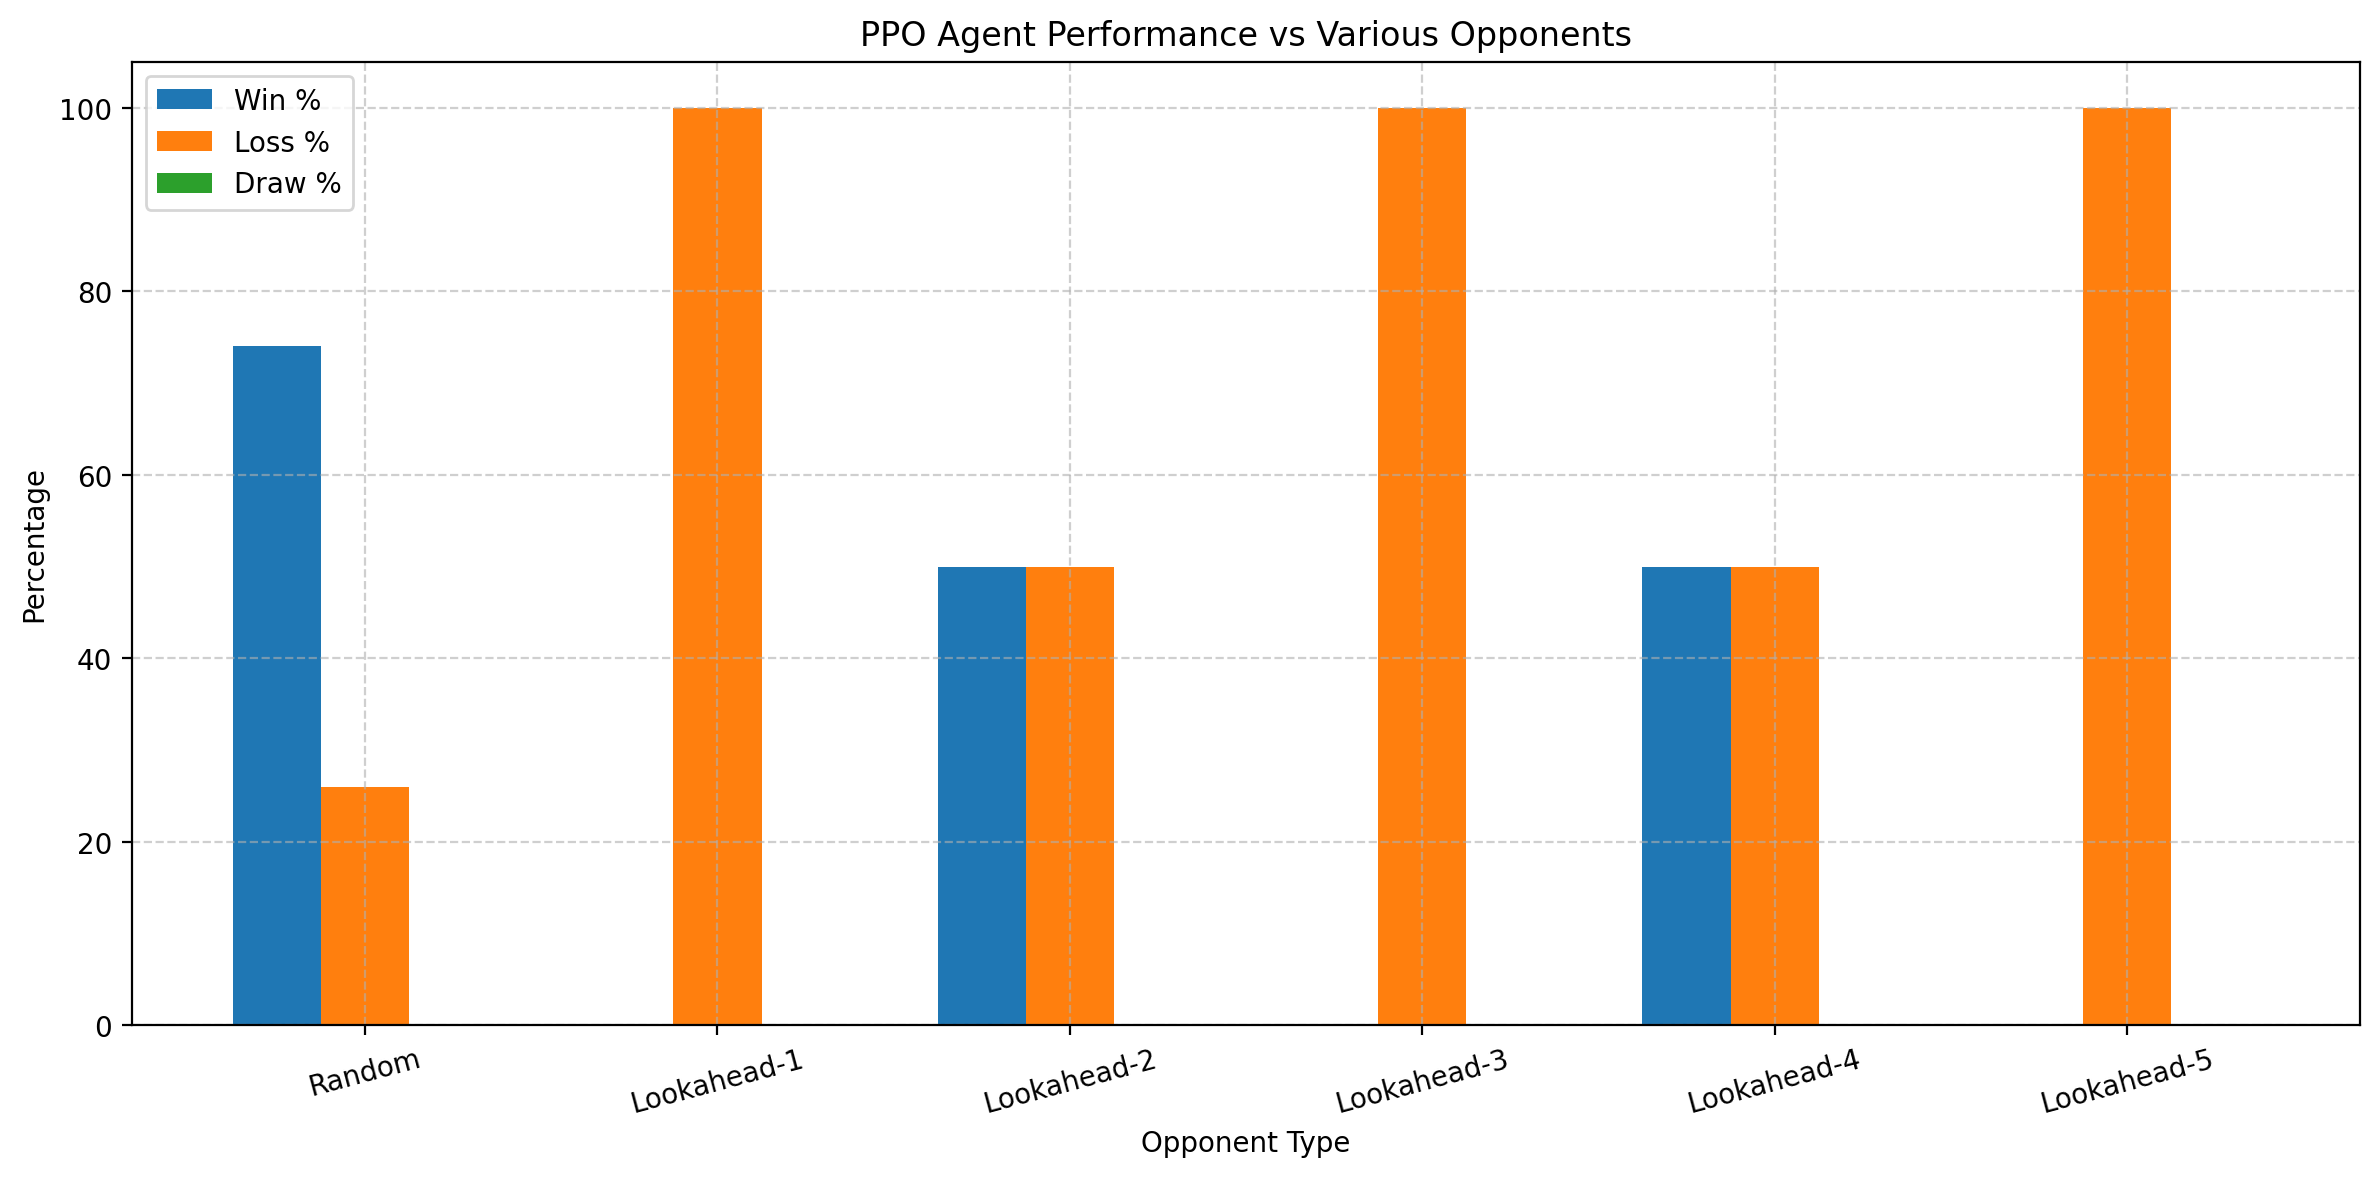

In [35]:
# --- Text summary ---
print("📊 Evaluation Summary:")
for label, s in evaluation_results.items():
    print(f"{label:>11}: {s['wins']}W / {s['losses']}L / {s['draws']}D → "
          f"Win {s['win_rate']*100:.1f}% | Loss {s['loss_rate']*100:.1f}% | Draw {s['draw_rate']*100:.1f}%")

# --- Plot ---
labels = list(evaluation_results.keys())
win_rates  = [evaluation_results[k]['win_rate'] * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = np.arange(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %')
plt.bar(x + bar_width, loss_rates, width=bar_width, label='Loss %')
plt.bar(x + 2*bar_width, draw_rates, width=bar_width, label='Draw %')
plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('PPO Agent Performance vs Various Opponents')
plt.xticks(x + bar_width, labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Boards


🎯 Opponent: Random


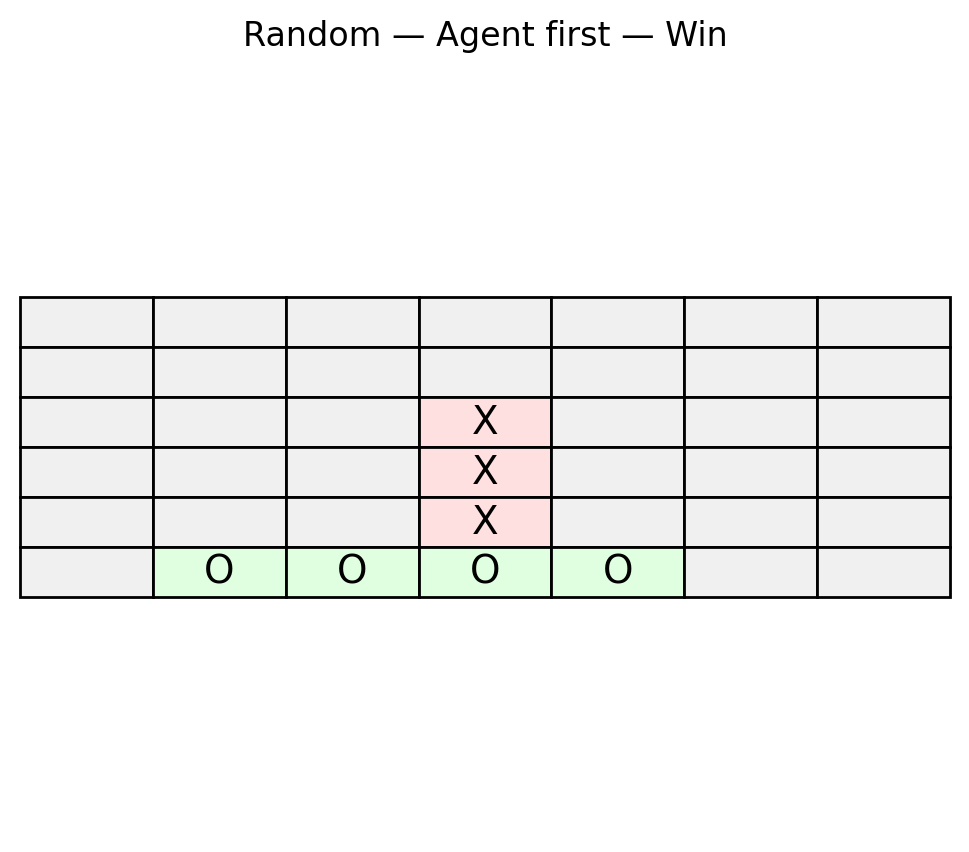

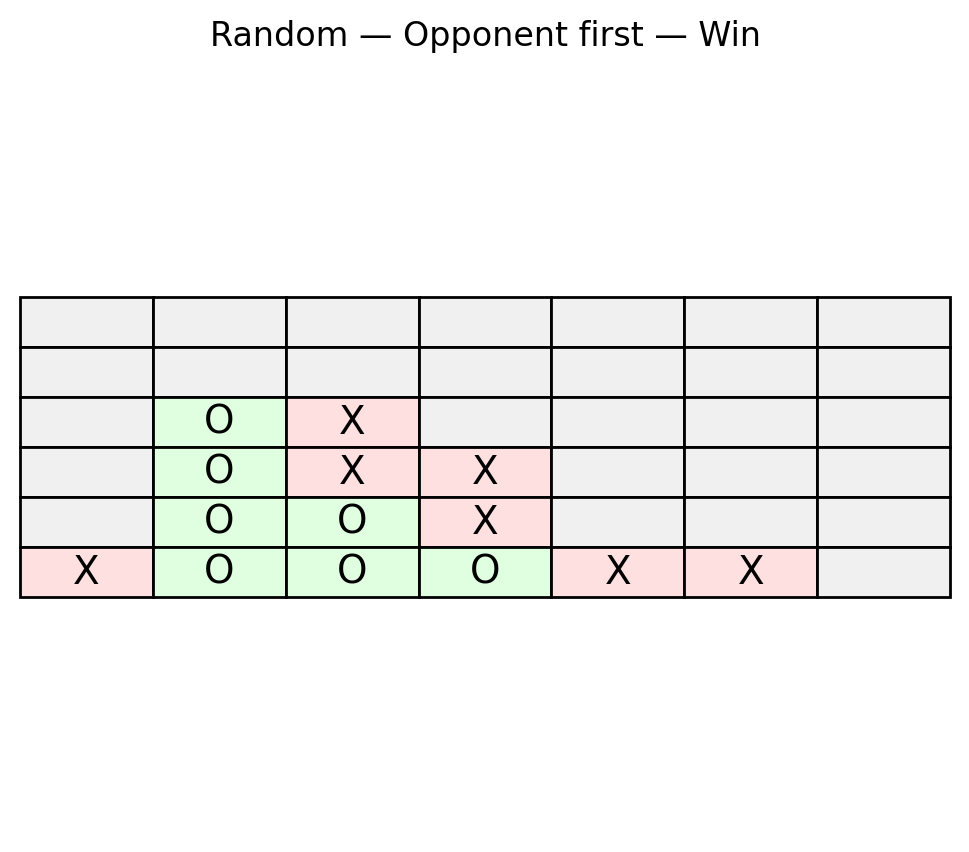

In [36]:
display_final_boards_PPO(policy, ["Random"])


🎯 Opponent: Lookahead-1


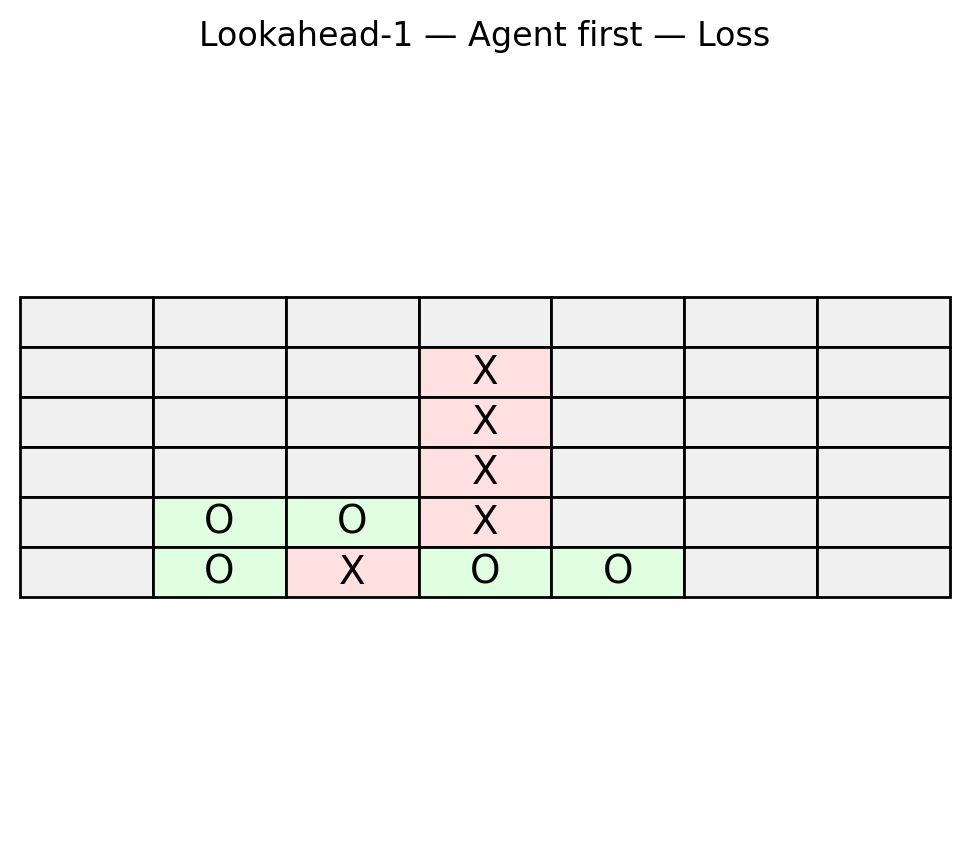

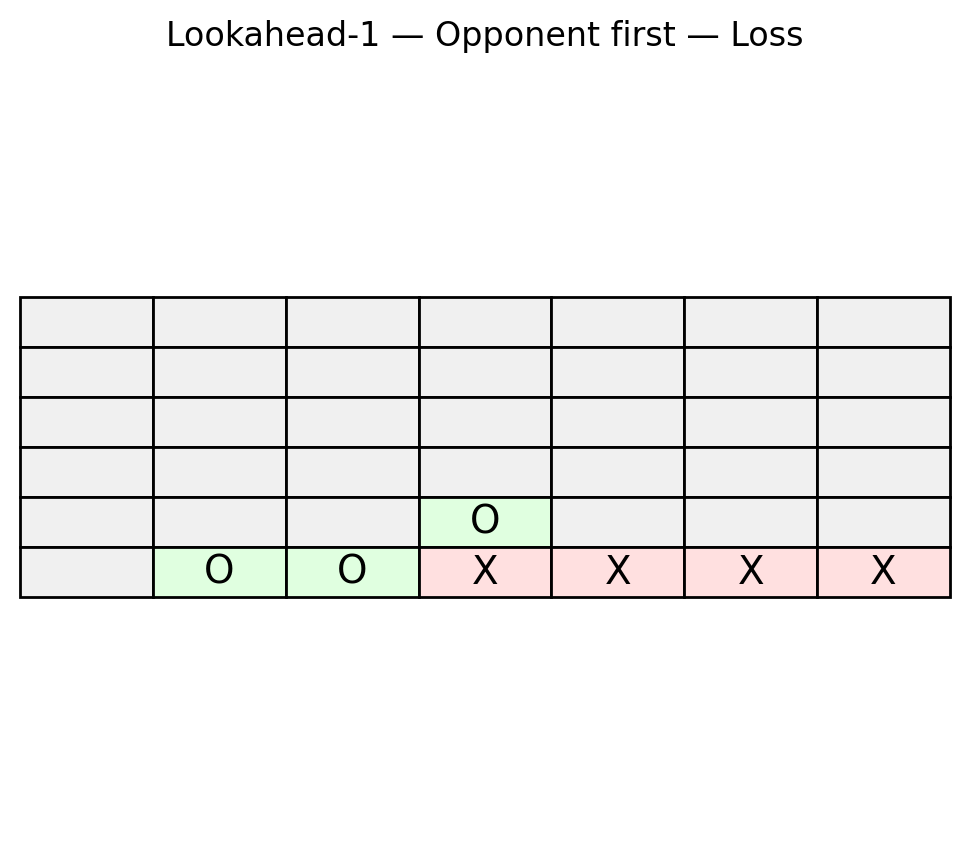

In [37]:
display_final_boards_PPO(policy, ["Lookahead-1"])


🎯 Opponent: Lookahead-2


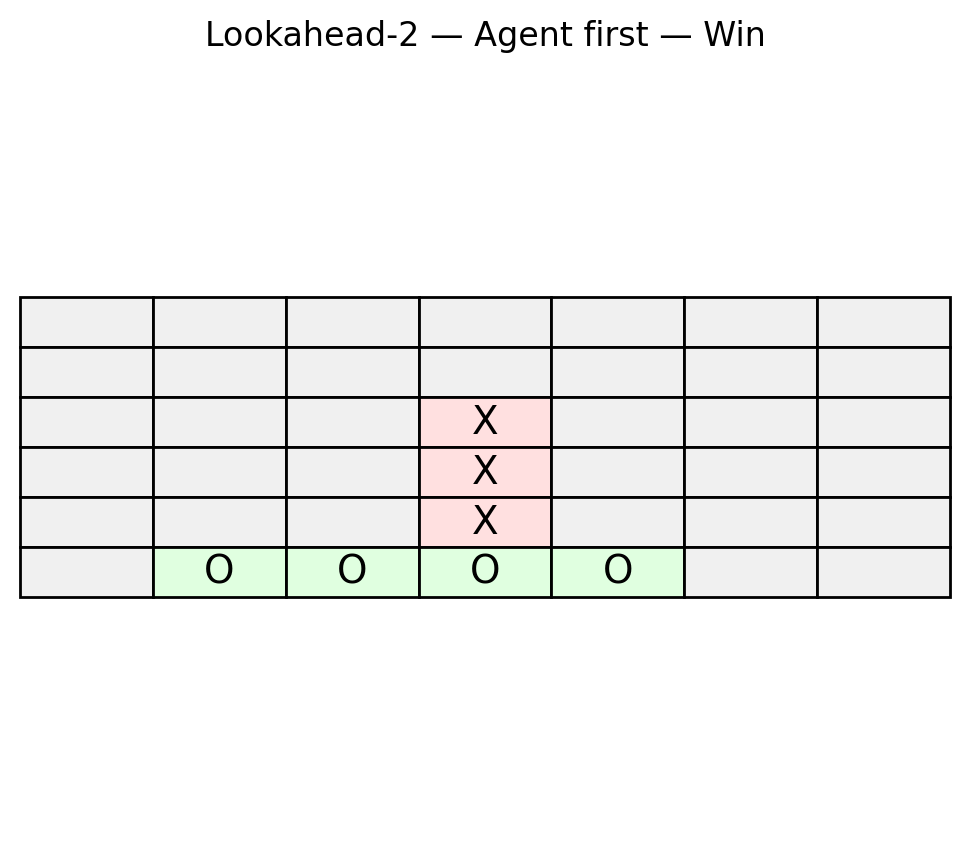

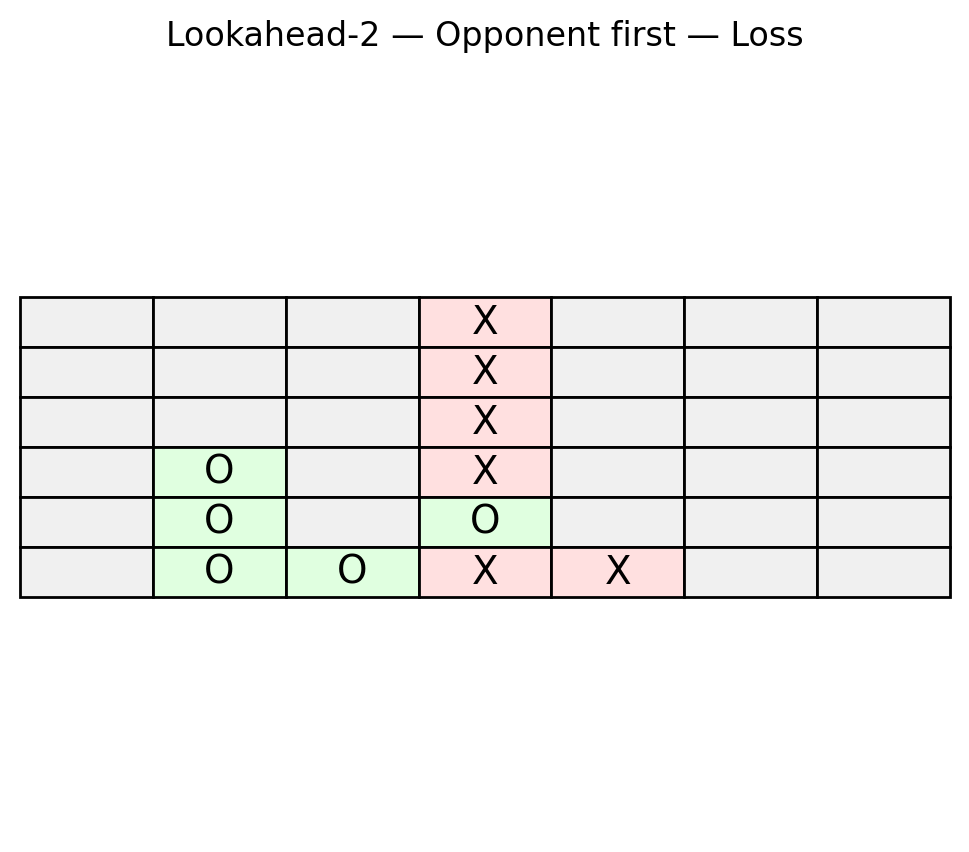

In [38]:
display_final_boards_PPO(policy, ["Lookahead-2"])


🎯 Opponent: Lookahead-3


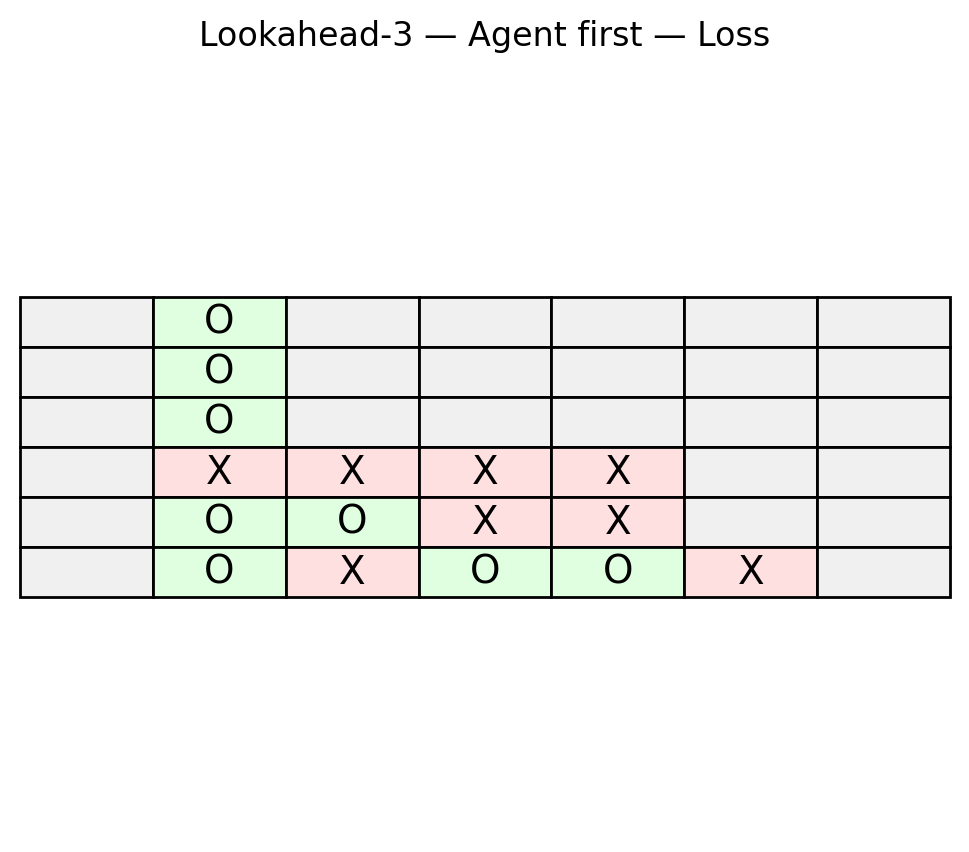

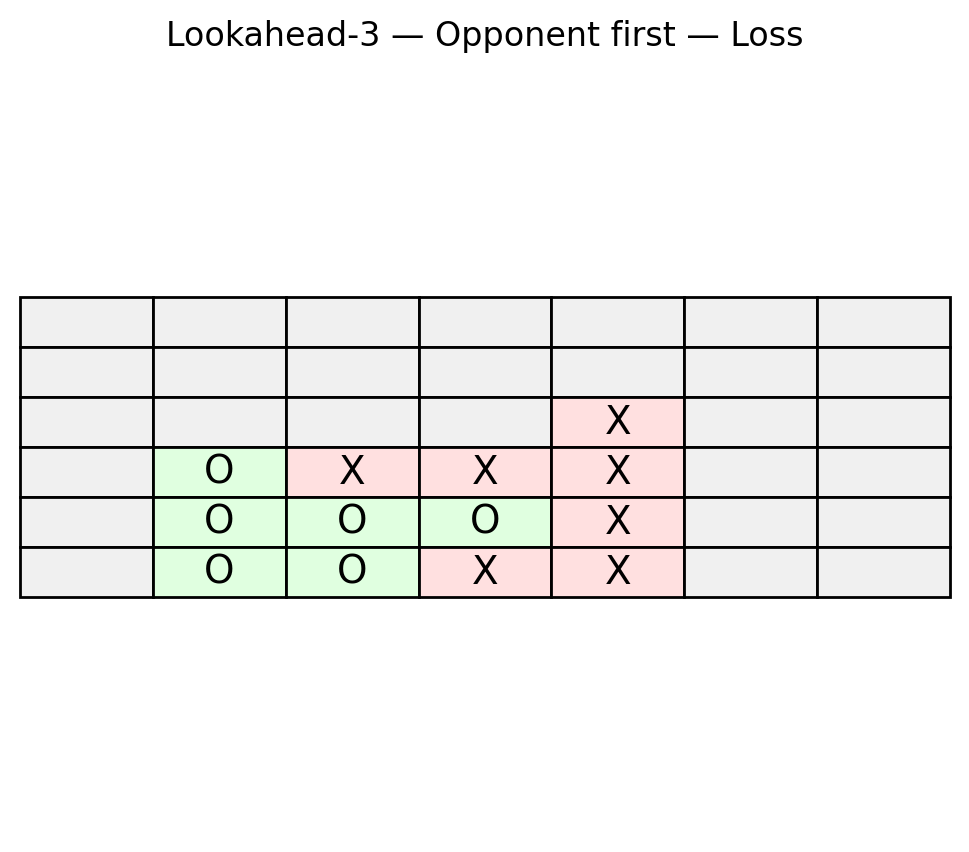

In [39]:
display_final_boards_PPO(policy, ["Lookahead-3"])


🎯 Opponent: Lookahead-4


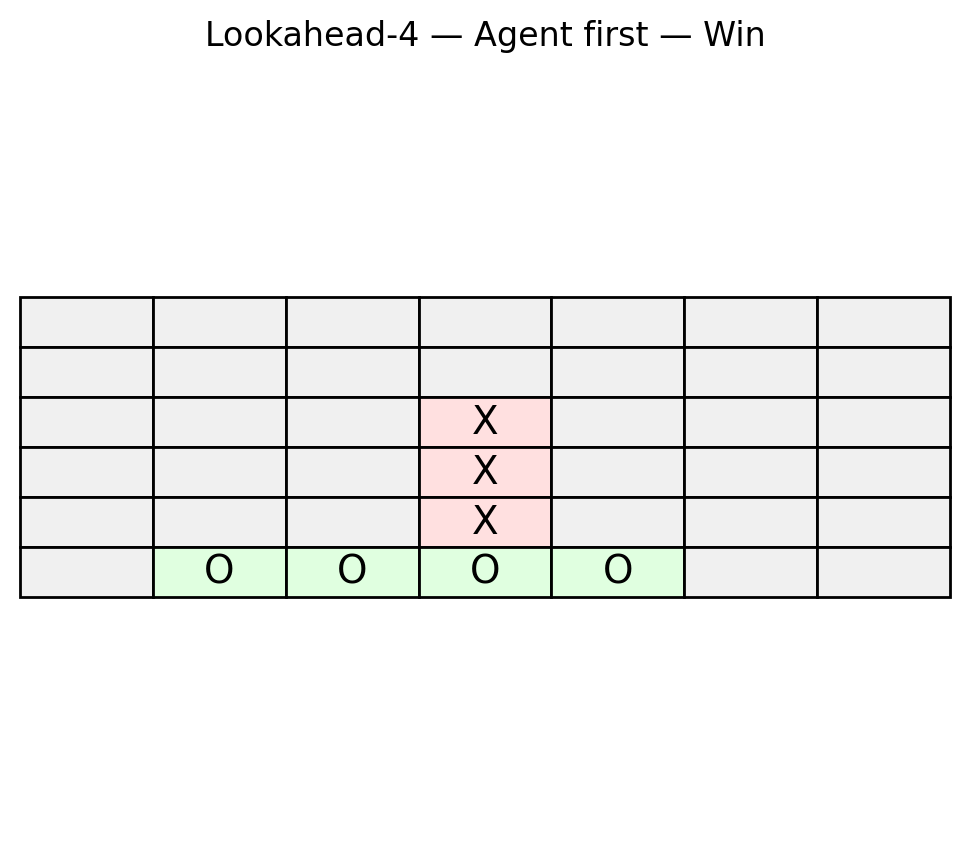

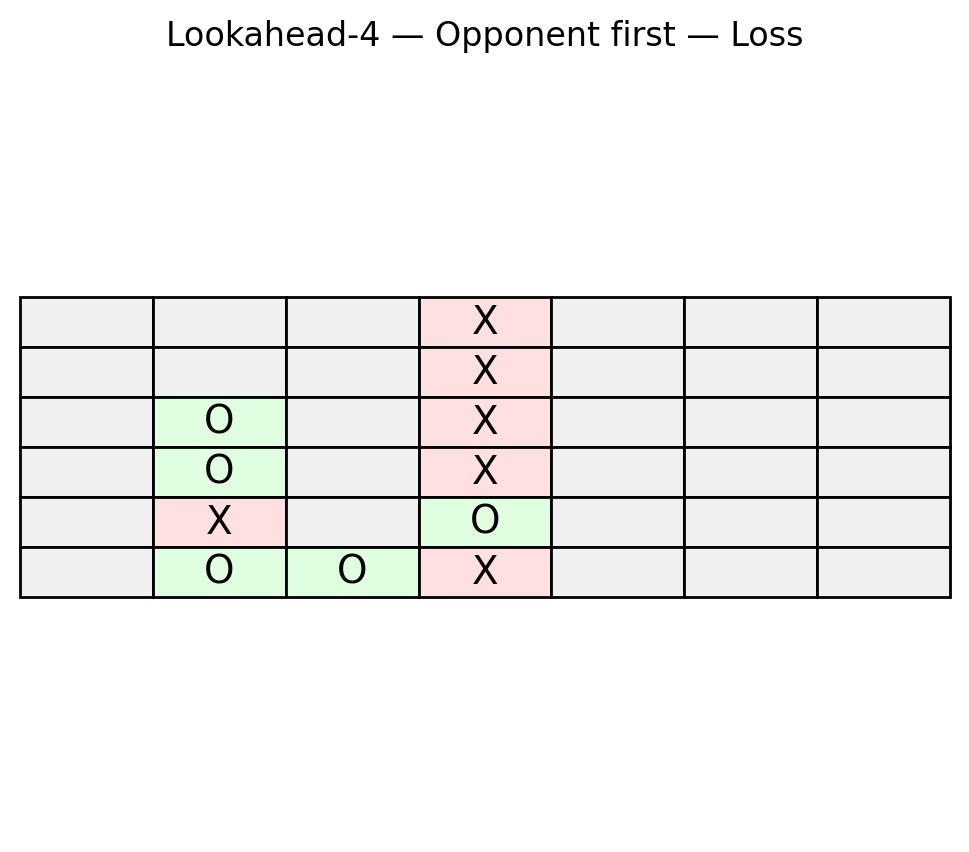

In [40]:
display_final_boards_PPO(policy, ["Lookahead-4"])


🎯 Opponent: Lookahead-5


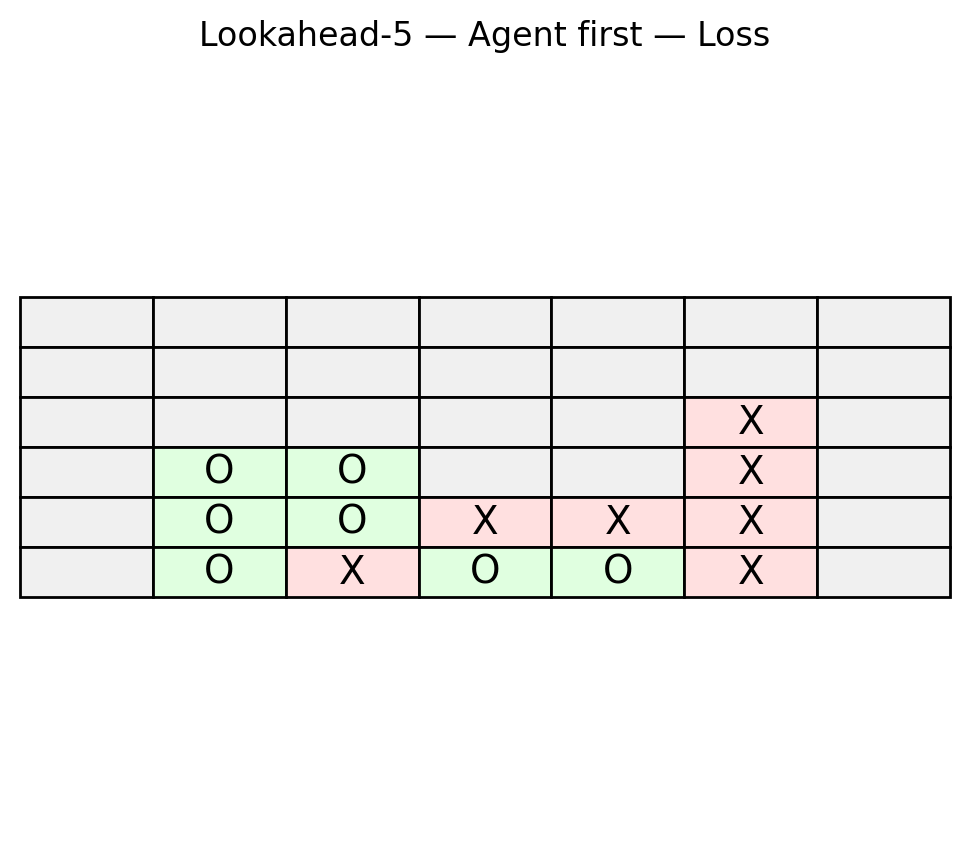

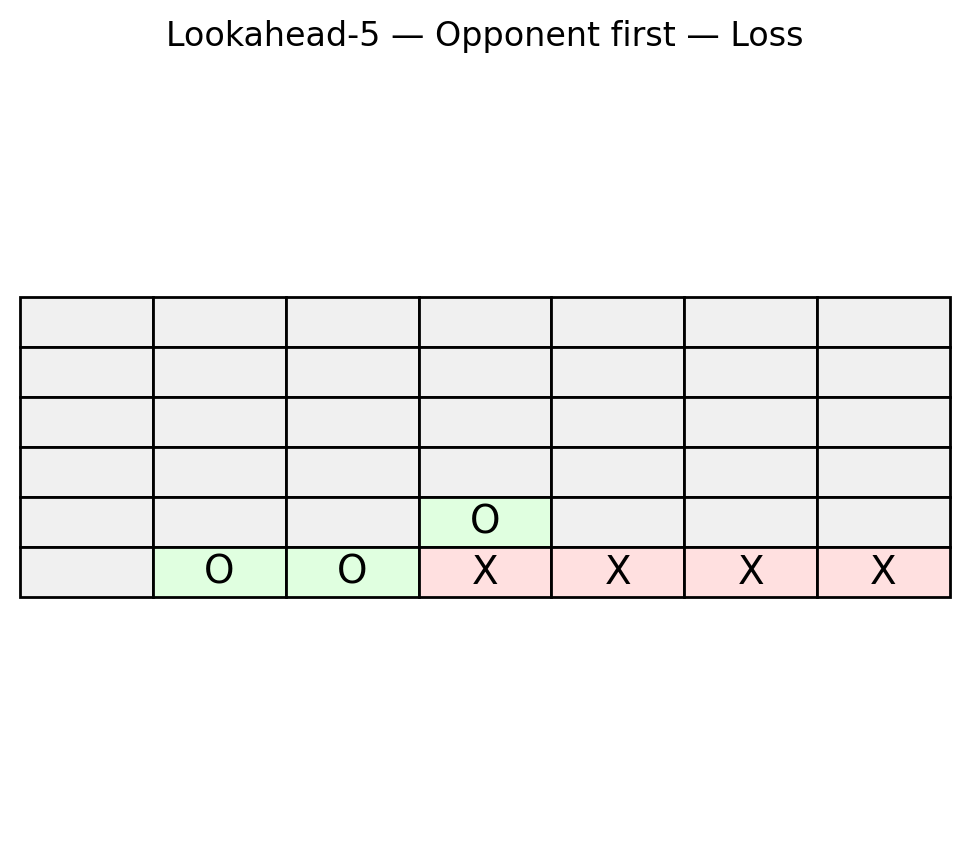

In [41]:
display_final_boards_PPO(policy, ["Lookahead-5"])

# DONE

In [42]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 0.2 hours
